In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(684288, 828)
(684288, 1)
validation
(113488, 828)
(113488, 1)
test
(56512, 828)
(56512, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/69 [..............................] - ETA: 1:51 - loss: 0.0783 - STD: 1.4504e-04 - MAE: 0.2623

 4/69 [>.............................] - ETA: 2s - loss: 0.0322 - STD: 3.4743e-04 - MAE: 0.1398  

 5/69 [=>............................] - ETA: 3s - loss: 0.0310 - STD: 3.1831e-04 - MAE: 0.1373

 6/69 [=>............................] - ETA: 4s - loss: 0.0304 - STD: 2.9059e-04 - MAE: 0.1367

 7/69 [==>...........................] - ETA: 4s - loss: 0.0301 - STD: 2.6607e-04 - MAE: 0.1365

 8/69 [==>...........................] - ETA: 4s - loss: 0.0298 - STD: 2.4471e-04 - MAE: 0.1358

 9/69 [==>...........................] - ETA: 5s - loss: 0.0294 - STD: 2.2621e-04 - MAE: 0.1348

10/69 [===>..........................] - ETA: 5s - loss: 0.0288 - STD: 2.1013e-04 - MAE: 0.1330

11/69 [===>..........................] - ETA: 5s - loss: 0.0280 - STD: 1.9639e-04 - MAE: 0.1305

12/69 [====>.........................] - ETA: 5s - loss: 0.0272 - STD: 1.8478e-04 - MAE: 0.1276

13/69 [====>.........................] - ETA: 5s - loss: 0.0262 - STD: 1.7521e-04 - MAE: 0.1244

14/69 [=====>........................] - ETA: 5s - loss: 0.0251 - STD: 1.6733e-04 - MAE: 0.1212

15/69 [=====>........................] - ETA: 5s - loss: 0.0242 - STD: 1.6070e-04 - MAE: 0.1185

16/69 [=====>........................] - ETA: 5s - loss: 0.0234 - STD: 1.5502e-04 - MAE: 0.1166

17/69 [======>.......................] - ETA: 4s - loss: 0.0228 - STD: 1.4997e-04 - MAE: 0.1152

18/69 [======>.......................] - ETA: 4s - loss: 0.0223 - STD: 1.4529e-04 - MAE: 0.1145

19/69 [=======>......................] - ETA: 4s - loss: 0.0219 - STD: 1.4096e-04 - MAE: 0.1140

20/69 [=======>......................] - ETA: 4s - loss: 0.0215 - STD: 1.3698e-04 - MAE: 0.1136

21/69 [========>.....................] - ETA: 4s - loss: 0.0212 - STD: 1.3342e-04 - MAE: 0.1130

22/69 [========>.....................] - ETA: 4s - loss: 0.0208 - STD: 1.3023e-04 - MAE: 0.1122

23/69 [=========>....................] - ETA: 4s - loss: 0.0204 - STD: 1.2749e-04 - MAE: 0.1112

24/69 [=========>....................] - ETA: 4s - loss: 0.0200 - STD: 1.2510e-04 - MAE: 0.1101

25/69 [=========>....................] - ETA: 4s - loss: 0.0197 - STD: 1.2301e-04 - MAE: 0.1089

26/69 [==========>...................] - ETA: 5s - loss: 0.0195 - STD: 1.2121e-04 - MAE: 0.1079

29/69 [===========>..................] - ETA: 4s - loss: 0.0187 - STD: 1.1686e-04 - MAE: 0.1050

30/69 [============>.................] - ETA: 4s - loss: 0.0185 - STD: 1.1574e-04 - MAE: 0.1042

31/69 [============>.................] - ETA: 4s - loss: 0.0183 - STD: 1.1476e-04 - MAE: 0.1034

32/69 [============>.................] - ETA: 4s - loss: 0.0181 - STD: 1.1392e-04 - MAE: 0.1027

33/69 [=============>................] - ETA: 4s - loss: 0.0179 - STD: 1.1324e-04 - MAE: 0.1020

34/69 [=============>................] - ETA: 3s - loss: 0.0177 - STD: 1.1269e-04 - MAE: 0.1013

35/69 [==============>...............] - ETA: 3s - loss: 0.0175 - STD: 1.1228e-04 - MAE: 0.1007

36/69 [==============>...............] - ETA: 3s - loss: 0.0173 - STD: 1.1200e-04 - MAE: 0.1002

37/69 [===============>..............] - ETA: 3s - loss: 0.0171 - STD: 1.1185e-04 - MAE: 0.0997

38/69 [===============>..............] - ETA: 3s - loss: 0.0170 - STD: 1.1179e-04 - MAE: 0.0992

39/69 [===============>..............] - ETA: 3s - loss: 0.0168 - STD: 1.1183e-04 - MAE: 0.0989

40/69 [================>.............] - ETA: 3s - loss: 0.0167 - STD: 1.1196e-04 - MAE: 0.0986

41/69 [================>.............] - ETA: 3s - loss: 0.0165 - STD: 1.1222e-04 - MAE: 0.0983

42/69 [=================>............] - ETA: 3s - loss: 0.0164 - STD: 1.1250e-04 - MAE: 0.0980

43/69 [=================>............] - ETA: 2s - loss: 0.0163 - STD: 1.1289e-04 - MAE: 0.0977

44/69 [==================>...........] - ETA: 2s - loss: 0.0162 - STD: 1.1333e-04 - MAE: 0.0975

45/69 [==================>...........] - ETA: 2s - loss: 0.0161 - STD: 1.1380e-04 - MAE: 0.0972

46/69 [===================>..........] - ETA: 2s - loss: 0.0159 - STD: 1.1435e-04 - MAE: 0.0969

47/69 [===================>..........] - ETA: 2s - loss: 0.0158 - STD: 1.1492e-04 - MAE: 0.0966

48/69 [===================>..........] - ETA: 2s - loss: 0.0157 - STD: 1.1553e-04 - MAE: 0.0963

49/69 [====================>.........] - ETA: 2s - loss: 0.0156 - STD: 1.1612e-04 - MAE: 0.0960

50/69 [====================>.........] - ETA: 2s - loss: 0.0155 - STD: 1.1676e-04 - MAE: 0.0957

51/69 [=====================>........] - ETA: 2s - loss: 0.0155 - STD: 1.1746e-04 - MAE: 0.0954

52/69 [=====================>........] - ETA: 1s - loss: 0.0154 - STD: 1.1821e-04 - MAE: 0.0951

53/69 [======================>.......] - ETA: 1s - loss: 0.0153 - STD: 1.1900e-04 - MAE: 0.0948

54/69 [======================>.......] - ETA: 1s - loss: 0.0152 - STD: 1.1988e-04 - MAE: 0.0945

55/69 [======================>.......] - ETA: 1s - loss: 0.0151 - STD: 1.2079e-04 - MAE: 0.0943

56/69 [=======================>......] - ETA: 1s - loss: 0.0151 - STD: 1.2177e-04 - MAE: 0.0940

57/69 [=======================>......] - ETA: 1s - loss: 0.0150 - STD: 1.2281e-04 - MAE: 0.0938

58/69 [========================>.....] - ETA: 1s - loss: 0.0149 - STD: 1.2392e-04 - MAE: 0.0936

59/69 [========================>.....] - ETA: 1s - loss: 0.0148 - STD: 1.2509e-04 - MAE: 0.0934

60/69 [=========================>....] - ETA: 0s - loss: 0.0148 - STD: 1.2634e-04 - MAE: 0.0932

61/69 [=========================>....] - ETA: 0s - loss: 0.0147 - STD: 1.2766e-04 - MAE: 0.0931

62/69 [=========================>....] - ETA: 0s - loss: 0.0146 - STD: 1.2898e-04 - MAE: 0.0929

63/69 [==========================>...] - ETA: 0s - loss: 0.0146 - STD: 1.3039e-04 - MAE: 0.0928

64/69 [==========================>...] - ETA: 0s - loss: 0.0145 - STD: 1.3184e-04 - MAE: 0.0926

65/69 [===========================>..] - ETA: 0s - loss: 0.0145 - STD: 1.3333e-04 - MAE: 0.0925

66/69 [===========================>..] - ETA: 0s - loss: 0.0144 - STD: 1.3484e-04 - MAE: 0.0923

67/69 [============================>.] - ETA: 0s - loss: 0.0144 - STD: 1.3639e-04 - MAE: 0.0922

68/69 [============================>.] - ETA: 0s - loss: 0.0143 - STD: 1.3798e-04 - MAE: 0.0920

69/69 [==============================] - ETA: 0s - loss: 0.0143 - STD: 1.3966e-04 - MAE: 0.0918

69/69 [==============================] - 10s 121ms/step - loss: 0.0143 - STD: 1.3966e-04 - MAE: 0.0918 - val_loss: 0.0128 - val_STD: 2.0051e-04 - val_MAE: 0.0859


Epoch 2/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0109 - STD: 2.5779e-04 - MAE: 0.0817

 2/69 [..............................] - ETA: 7s - loss: 0.0111 - STD: 2.6088e-04 - MAE: 0.0817

 3/69 [>.............................] - ETA: 7s - loss: 0.0109 - STD: 2.6341e-04 - MAE: 0.0812

 4/69 [>.............................] - ETA: 7s - loss: 0.0109 - STD: 2.6746e-04 - MAE: 0.0811

 5/69 [=>............................] - ETA: 6s - loss: 0.0109 - STD: 2.7165e-04 - MAE: 0.0813

 6/69 [=>............................] - ETA: 6s - loss: 0.0109 - STD: 2.7531e-04 - MAE: 0.0811

 7/69 [==>...........................] - ETA: 6s - loss: 0.0109 - STD: 2.7965e-04 - MAE: 0.0813

 8/69 [==>...........................] - ETA: 6s - loss: 0.0109 - STD: 2.8374e-04 - MAE: 0.0813

 9/69 [==>...........................] - ETA: 6s - loss: 0.0109 - STD: 2.8822e-04 - MAE: 0.0812

10/69 [===>..........................] - ETA: 6s - loss: 0.0109 - STD: 2.9276e-04 - MAE: 0.0813

11/69 [===>..........................] - ETA: 6s - loss: 0.0108 - STD: 2.9721e-04 - MAE: 0.0814

12/69 [====>.........................] - ETA: 6s - loss: 0.0109 - STD: 3.0185e-04 - MAE: 0.0815

13/69 [====>.........................] - ETA: 5s - loss: 0.0109 - STD: 3.0633e-04 - MAE: 0.0815

14/69 [=====>........................] - ETA: 5s - loss: 0.0109 - STD: 3.1117e-04 - MAE: 0.0816

15/69 [=====>........................] - ETA: 5s - loss: 0.0109 - STD: 3.1606e-04 - MAE: 0.0817

16/69 [=====>........................] - ETA: 5s - loss: 0.0109 - STD: 3.2124e-04 - MAE: 0.0818

17/69 [======>.......................] - ETA: 5s - loss: 0.0109 - STD: 3.2623e-04 - MAE: 0.0817

18/69 [======>.......................] - ETA: 5s - loss: 0.0109 - STD: 3.3143e-04 - MAE: 0.0816

19/69 [=======>......................] - ETA: 5s - loss: 0.0109 - STD: 3.3664e-04 - MAE: 0.0816

20/69 [=======>......................] - ETA: 5s - loss: 0.0109 - STD: 3.4193e-04 - MAE: 0.0816

21/69 [========>.....................] - ETA: 5s - loss: 0.0109 - STD: 3.4723e-04 - MAE: 0.0816

22/69 [========>.....................] - ETA: 5s - loss: 0.0109 - STD: 3.5293e-04 - MAE: 0.0816

23/69 [=========>....................] - ETA: 4s - loss: 0.0109 - STD: 3.5891e-04 - MAE: 0.0817

24/69 [=========>....................] - ETA: 4s - loss: 0.0109 - STD: 3.6481e-04 - MAE: 0.0817

25/69 [=========>....................] - ETA: 4s - loss: 0.0109 - STD: 3.7090e-04 - MAE: 0.0816

26/69 [==========>...................] - ETA: 4s - loss: 0.0109 - STD: 3.7737e-04 - MAE: 0.0817

27/69 [==========>...................] - ETA: 4s - loss: 0.0109 - STD: 3.8414e-04 - MAE: 0.0817

28/69 [===========>..................] - ETA: 4s - loss: 0.0109 - STD: 3.9092e-04 - MAE: 0.0817

29/69 [===========>..................] - ETA: 4s - loss: 0.0109 - STD: 3.9793e-04 - MAE: 0.0817

30/69 [============>.................] - ETA: 4s - loss: 0.0109 - STD: 4.0538e-04 - MAE: 0.0817

31/69 [============>.................] - ETA: 4s - loss: 0.0109 - STD: 4.1286e-04 - MAE: 0.0817

32/69 [============>.................] - ETA: 3s - loss: 0.0109 - STD: 4.2055e-04 - MAE: 0.0817

33/69 [=============>................] - ETA: 3s - loss: 0.0109 - STD: 4.2843e-04 - MAE: 0.0817

34/69 [=============>................] - ETA: 3s - loss: 0.0109 - STD: 4.3651e-04 - MAE: 0.0818

35/69 [==============>...............] - ETA: 3s - loss: 0.0109 - STD: 4.4490e-04 - MAE: 0.0818

36/69 [==============>...............] - ETA: 3s - loss: 0.0109 - STD: 4.5359e-04 - MAE: 0.0818

37/69 [===============>..............] - ETA: 3s - loss: 0.0109 - STD: 4.6249e-04 - MAE: 0.0818

38/69 [===============>..............] - ETA: 3s - loss: 0.0109 - STD: 4.7190e-04 - MAE: 0.0818

39/69 [===============>..............] - ETA: 3s - loss: 0.0109 - STD: 4.8142e-04 - MAE: 0.0818

40/69 [================>.............] - ETA: 3s - loss: 0.0109 - STD: 4.9147e-04 - MAE: 0.0818

41/69 [================>.............] - ETA: 3s - loss: 0.0109 - STD: 5.0181e-04 - MAE: 0.0818

42/69 [=================>............] - ETA: 2s - loss: 0.0109 - STD: 5.1236e-04 - MAE: 0.0818

43/69 [=================>............] - ETA: 2s - loss: 0.0109 - STD: 5.2333e-04 - MAE: 0.0818

44/69 [==================>...........] - ETA: 2s - loss: 0.0109 - STD: 5.3485e-04 - MAE: 0.0817

45/69 [==================>...........] - ETA: 2s - loss: 0.0109 - STD: 5.4694e-04 - MAE: 0.0817

46/69 [===================>..........] - ETA: 2s - loss: 0.0109 - STD: 5.5938e-04 - MAE: 0.0817

47/69 [===================>..........] - ETA: 2s - loss: 0.0109 - STD: 5.7252e-04 - MAE: 0.0817

48/69 [===================>..........] - ETA: 2s - loss: 0.0109 - STD: 5.8592e-04 - MAE: 0.0817

49/69 [====================>.........] - ETA: 2s - loss: 0.0109 - STD: 5.9983e-04 - MAE: 0.0817

50/69 [====================>.........] - ETA: 2s - loss: 0.0109 - STD: 6.1441e-04 - MAE: 0.0817

51/69 [=====================>........] - ETA: 1s - loss: 0.0109 - STD: 6.2926e-04 - MAE: 0.0817

52/69 [=====================>........] - ETA: 1s - loss: 0.0109 - STD: 6.4486e-04 - MAE: 0.0817

53/69 [======================>.......] - ETA: 1s - loss: 0.0109 - STD: 6.6145e-04 - MAE: 0.0817

54/69 [======================>.......] - ETA: 1s - loss: 0.0109 - STD: 6.7838e-04 - MAE: 0.0817

55/69 [======================>.......] - ETA: 1s - loss: 0.0109 - STD: 6.9657e-04 - MAE: 0.0817

56/69 [=======================>......] - ETA: 1s - loss: 0.0109 - STD: 7.1562e-04 - MAE: 0.0817

57/69 [=======================>......] - ETA: 1s - loss: 0.0109 - STD: 7.3519e-04 - MAE: 0.0817

58/69 [========================>.....] - ETA: 1s - loss: 0.0109 - STD: 7.5563e-04 - MAE: 0.0817

59/69 [========================>.....] - ETA: 1s - loss: 0.0109 - STD: 7.7732e-04 - MAE: 0.0817

60/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 7.9953e-04 - MAE: 0.0817

61/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 8.2317e-04 - MAE: 0.0817

62/69 [=========================>....] - ETA: 0s - loss: 0.0109 - STD: 8.4803e-04 - MAE: 0.0817

63/69 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 8.7418e-04 - MAE: 0.0817

64/69 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 9.0201e-04 - MAE: 0.0817

65/69 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 9.3124e-04 - MAE: 0.0817

66/69 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 9.6230e-04 - MAE: 0.0817

68/69 [============================>.] - ETA: 0s - loss: 0.0109 - STD: 0.0010 - MAE: 0.0816    

69/69 [==============================] - ETA: 0s - loss: 0.0109 - STD: 0.0011 - MAE: 0.0816

69/69 [==============================] - 8s 110ms/step - loss: 0.0109 - STD: 0.0011 - MAE: 0.0816 - val_loss: 0.0124 - val_STD: 0.0029 - val_MAE: 0.0852


Epoch 3/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0105 - STD: 0.0037 - MAE: 0.0810

 2/69 [..............................] - ETA: 7s - loss: 0.0107 - STD: 0.0038 - MAE: 0.0812

 3/69 [>.............................] - ETA: 7s - loss: 0.0107 - STD: 0.0039 - MAE: 0.0815

 4/69 [>.............................] - ETA: 7s - loss: 0.0107 - STD: 0.0041 - MAE: 0.0813

 5/69 [=>............................] - ETA: 6s - loss: 0.0106 - STD: 0.0042 - MAE: 0.0809

 6/69 [=>............................] - ETA: 6s - loss: 0.0106 - STD: 0.0043 - MAE: 0.0807

 7/69 [==>...........................] - ETA: 6s - loss: 0.0105 - STD: 0.0045 - MAE: 0.0806

 8/69 [==>...........................] - ETA: 6s - loss: 0.0105 - STD: 0.0046 - MAE: 0.0804

 9/69 [==>...........................] - ETA: 6s - loss: 0.0104 - STD: 0.0048 - MAE: 0.0802

10/69 [===>..........................] - ETA: 6s - loss: 0.0104 - STD: 0.0050 - MAE: 0.0802

11/69 [===>..........................] - ETA: 6s - loss: 0.0104 - STD: 0.0051 - MAE: 0.0802

12/69 [====>.........................] - ETA: 6s - loss: 0.0104 - STD: 0.0053 - MAE: 0.0801

13/69 [====>.........................] - ETA: 6s - loss: 0.0104 - STD: 0.0055 - MAE: 0.0801

14/69 [=====>........................] - ETA: 5s - loss: 0.0104 - STD: 0.0057 - MAE: 0.0801

15/69 [=====>........................] - ETA: 5s - loss: 0.0104 - STD: 0.0060 - MAE: 0.0801

16/69 [=====>........................] - ETA: 5s - loss: 0.0104 - STD: 0.0062 - MAE: 0.0800

17/69 [======>.......................] - ETA: 5s - loss: 0.0104 - STD: 0.0065 - MAE: 0.0800

18/69 [======>.......................] - ETA: 5s - loss: 0.0103 - STD: 0.0067 - MAE: 0.0799

19/69 [=======>......................] - ETA: 5s - loss: 0.0103 - STD: 0.0070 - MAE: 0.0799

21/69 [========>.....................] - ETA: 5s - loss: 0.0103 - STD: 0.0076 - MAE: 0.0798

22/69 [========>.....................] - ETA: 4s - loss: 0.0103 - STD: 0.0079 - MAE: 0.0798

23/69 [=========>....................] - ETA: 4s - loss: 0.0103 - STD: 0.0082 - MAE: 0.0797

24/69 [=========>....................] - ETA: 4s - loss: 0.0102 - STD: 0.0086 - MAE: 0.0795

25/69 [=========>....................] - ETA: 4s - loss: 0.0102 - STD: 0.0090 - MAE: 0.0794

26/69 [==========>...................] - ETA: 4s - loss: 0.0102 - STD: 0.0093 - MAE: 0.0794

27/69 [==========>...................] - ETA: 4s - loss: 0.0102 - STD: 0.0097 - MAE: 0.0793

28/69 [===========>..................] - ETA: 4s - loss: 0.0101 - STD: 0.0101 - MAE: 0.0792

29/69 [===========>..................] - ETA: 4s - loss: 0.0101 - STD: 0.0106 - MAE: 0.0791

30/69 [============>.................] - ETA: 4s - loss: 0.0101 - STD: 0.0110 - MAE: 0.0789

31/69 [============>.................] - ETA: 4s - loss: 0.0101 - STD: 0.0115 - MAE: 0.0788

32/69 [============>.................] - ETA: 3s - loss: 0.0100 - STD: 0.0119 - MAE: 0.0787

33/69 [=============>................] - ETA: 3s - loss: 0.0100 - STD: 0.0124 - MAE: 0.0786

34/69 [=============>................] - ETA: 3s - loss: 0.0100 - STD: 0.0129 - MAE: 0.0785

35/69 [==============>...............] - ETA: 3s - loss: 0.0099 - STD: 0.0134 - MAE: 0.0784

36/69 [==============>...............] - ETA: 3s - loss: 0.0099 - STD: 0.0139 - MAE: 0.0783

37/69 [===============>..............] - ETA: 3s - loss: 0.0099 - STD: 0.0145 - MAE: 0.0783

38/69 [===============>..............] - ETA: 3s - loss: 0.0099 - STD: 0.0150 - MAE: 0.0782

39/69 [===============>..............] - ETA: 3s - loss: 0.0099 - STD: 0.0155 - MAE: 0.0780

40/69 [================>.............] - ETA: 3s - loss: 0.0098 - STD: 0.0160 - MAE: 0.0779

41/69 [================>.............] - ETA: 2s - loss: 0.0098 - STD: 0.0166 - MAE: 0.0778

42/69 [=================>............] - ETA: 2s - loss: 0.0098 - STD: 0.0171 - MAE: 0.0777

43/69 [=================>............] - ETA: 2s - loss: 0.0098 - STD: 0.0176 - MAE: 0.0776

44/69 [==================>...........] - ETA: 2s - loss: 0.0097 - STD: 0.0181 - MAE: 0.0775

45/69 [==================>...........] - ETA: 2s - loss: 0.0097 - STD: 0.0186 - MAE: 0.0774

46/69 [===================>..........] - ETA: 2s - loss: 0.0097 - STD: 0.0192 - MAE: 0.0773

47/69 [===================>..........] - ETA: 2s - loss: 0.0097 - STD: 0.0197 - MAE: 0.0771

48/69 [===================>..........] - ETA: 2s - loss: 0.0096 - STD: 0.0201 - MAE: 0.0770

49/69 [====================>.........] - ETA: 2s - loss: 0.0096 - STD: 0.0206 - MAE: 0.0770

50/69 [====================>.........] - ETA: 2s - loss: 0.0096 - STD: 0.0210 - MAE: 0.0769

51/69 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0215 - MAE: 0.0768

52/69 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0219 - MAE: 0.0767

53/69 [======================>.......] - ETA: 1s - loss: 0.0095 - STD: 0.0223 - MAE: 0.0766

54/69 [======================>.......] - ETA: 1s - loss: 0.0095 - STD: 0.0227 - MAE: 0.0765

55/69 [======================>.......] - ETA: 1s - loss: 0.0095 - STD: 0.0231 - MAE: 0.0764

56/69 [=======================>......] - ETA: 1s - loss: 0.0095 - STD: 0.0234 - MAE: 0.0763

57/69 [=======================>......] - ETA: 1s - loss: 0.0094 - STD: 0.0238 - MAE: 0.0762

58/69 [========================>.....] - ETA: 1s - loss: 0.0094 - STD: 0.0241 - MAE: 0.0761

59/69 [========================>.....] - ETA: 1s - loss: 0.0094 - STD: 0.0245 - MAE: 0.0760

60/69 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0248 - MAE: 0.0759

61/69 [=========================>....] - ETA: 0s - loss: 0.0094 - STD: 0.0252 - MAE: 0.0758

62/69 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.0255 - MAE: 0.0757

63/69 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0259 - MAE: 0.0756

64/69 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.0262 - MAE: 0.0755

65/69 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0265 - MAE: 0.0754

66/69 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.0269 - MAE: 0.0753

67/69 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0272 - MAE: 0.0752

68/69 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 0.0275 - MAE: 0.0751

69/69 [==============================] - ETA: 0s - loss: 0.0092 - STD: 0.0279 - MAE: 0.0750

69/69 [==============================] - 8s 110ms/step - loss: 0.0092 - STD: 0.0279 - MAE: 0.0750 - val_loss: 0.0106 - val_STD: 0.0424 - val_MAE: 0.0797


Epoch 4/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0073 - STD: 0.0497 - MAE: 0.0662

 2/69 [..............................] - ETA: 7s - loss: 0.0073 - STD: 0.0499 - MAE: 0.0659

 3/69 [>.............................] - ETA: 7s - loss: 0.0073 - STD: 0.0504 - MAE: 0.0660

 4/69 [>.............................] - ETA: 7s - loss: 0.0073 - STD: 0.0512 - MAE: 0.0662

 5/69 [=>............................] - ETA: 7s - loss: 0.0073 - STD: 0.0514 - MAE: 0.0663

 6/69 [=>............................] - ETA: 7s - loss: 0.0073 - STD: 0.0516 - MAE: 0.0664

 7/69 [==>...........................] - ETA: 6s - loss: 0.0074 - STD: 0.0521 - MAE: 0.0665

 8/69 [==>...........................] - ETA: 6s - loss: 0.0074 - STD: 0.0525 - MAE: 0.0665

 9/69 [==>...........................] - ETA: 6s - loss: 0.0073 - STD: 0.0526 - MAE: 0.0662

10/69 [===>..........................] - ETA: 6s - loss: 0.0073 - STD: 0.0529 - MAE: 0.0662

11/69 [===>..........................] - ETA: 6s - loss: 0.0073 - STD: 0.0534 - MAE: 0.0663

12/69 [====>.........................] - ETA: 6s - loss: 0.0073 - STD: 0.0537 - MAE: 0.0663

13/69 [====>.........................] - ETA: 6s - loss: 0.0073 - STD: 0.0538 - MAE: 0.0661

14/69 [=====>........................] - ETA: 6s - loss: 0.0073 - STD: 0.0540 - MAE: 0.0660

16/69 [=====>........................] - ETA: 5s - loss: 0.0073 - STD: 0.0544 - MAE: 0.0659

17/69 [======>.......................] - ETA: 5s - loss: 0.0073 - STD: 0.0546 - MAE: 0.0658

18/69 [======>.......................] - ETA: 5s - loss: 0.0072 - STD: 0.0548 - MAE: 0.0658

19/69 [=======>......................] - ETA: 5s - loss: 0.0072 - STD: 0.0551 - MAE: 0.0657

20/69 [=======>......................] - ETA: 5s - loss: 0.0072 - STD: 0.0551 - MAE: 0.0656

21/69 [========>.....................] - ETA: 5s - loss: 0.0072 - STD: 0.0552 - MAE: 0.0655

22/69 [========>.....................] - ETA: 4s - loss: 0.0072 - STD: 0.0555 - MAE: 0.0655

23/69 [=========>....................] - ETA: 4s - loss: 0.0072 - STD: 0.0556 - MAE: 0.0654

24/69 [=========>....................] - ETA: 4s - loss: 0.0071 - STD: 0.0557 - MAE: 0.0653

25/69 [=========>....................] - ETA: 4s - loss: 0.0071 - STD: 0.0558 - MAE: 0.0652

26/69 [==========>...................] - ETA: 4s - loss: 0.0071 - STD: 0.0561 - MAE: 0.0651

27/69 [==========>...................] - ETA: 4s - loss: 0.0071 - STD: 0.0562 - MAE: 0.0650

28/69 [===========>..................] - ETA: 4s - loss: 0.0071 - STD: 0.0563 - MAE: 0.0650

29/69 [===========>..................] - ETA: 4s - loss: 0.0071 - STD: 0.0566 - MAE: 0.0649

30/69 [============>.................] - ETA: 4s - loss: 0.0071 - STD: 0.0569 - MAE: 0.0649

31/69 [============>.................] - ETA: 4s - loss: 0.0071 - STD: 0.0570 - MAE: 0.0648

32/69 [============>.................] - ETA: 3s - loss: 0.0071 - STD: 0.0571 - MAE: 0.0648

33/69 [=============>................] - ETA: 3s - loss: 0.0071 - STD: 0.0574 - MAE: 0.0648

34/69 [=============>................] - ETA: 3s - loss: 0.0070 - STD: 0.0575 - MAE: 0.0647

35/69 [==============>...............] - ETA: 3s - loss: 0.0070 - STD: 0.0576 - MAE: 0.0646

36/69 [==============>...............] - ETA: 3s - loss: 0.0070 - STD: 0.0578 - MAE: 0.0645

37/69 [===============>..............] - ETA: 3s - loss: 0.0070 - STD: 0.0580 - MAE: 0.0645

38/69 [===============>..............] - ETA: 3s - loss: 0.0070 - STD: 0.0581 - MAE: 0.0644

39/69 [===============>..............] - ETA: 3s - loss: 0.0070 - STD: 0.0582 - MAE: 0.0644

40/69 [================>.............] - ETA: 3s - loss: 0.0070 - STD: 0.0584 - MAE: 0.0644

41/69 [================>.............] - ETA: 2s - loss: 0.0070 - STD: 0.0585 - MAE: 0.0643

42/69 [=================>............] - ETA: 2s - loss: 0.0070 - STD: 0.0586 - MAE: 0.0643

43/69 [=================>............] - ETA: 2s - loss: 0.0070 - STD: 0.0588 - MAE: 0.0642

44/69 [==================>...........] - ETA: 2s - loss: 0.0070 - STD: 0.0589 - MAE: 0.0642

45/69 [==================>...........] - ETA: 2s - loss: 0.0070 - STD: 0.0590 - MAE: 0.0641

46/69 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0591 - MAE: 0.0641

47/69 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0592 - MAE: 0.0640

48/69 [===================>..........] - ETA: 2s - loss: 0.0069 - STD: 0.0593 - MAE: 0.0640

49/69 [====================>.........] - ETA: 2s - loss: 0.0069 - STD: 0.0594 - MAE: 0.0639

50/69 [====================>.........] - ETA: 2s - loss: 0.0069 - STD: 0.0595 - MAE: 0.0639

51/69 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0596 - MAE: 0.0638

52/69 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0597 - MAE: 0.0638

53/69 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0597 - MAE: 0.0638

54/69 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0598 - MAE: 0.0637

55/69 [======================>.......] - ETA: 1s - loss: 0.0069 - STD: 0.0599 - MAE: 0.0636

56/69 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0600 - MAE: 0.0636

57/69 [=======================>......] - ETA: 1s - loss: 0.0068 - STD: 0.0601 - MAE: 0.0635

58/69 [========================>.....] - ETA: 1s - loss: 0.0068 - STD: 0.0602 - MAE: 0.0635

59/69 [========================>.....] - ETA: 1s - loss: 0.0068 - STD: 0.0603 - MAE: 0.0634

60/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0603 - MAE: 0.0634

61/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0604 - MAE: 0.0633

62/69 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0605 - MAE: 0.0633

63/69 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0606 - MAE: 0.0633

64/69 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0607 - MAE: 0.0633

65/69 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0608 - MAE: 0.0632

66/69 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0608 - MAE: 0.0632

67/69 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0608 - MAE: 0.0632

68/69 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0609 - MAE: 0.0631

69/69 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0610 - MAE: 0.0631

69/69 [==============================] - 8s 110ms/step - loss: 0.0068 - STD: 0.0610 - MAE: 0.0631 - val_loss: 0.0093 - val_STD: 0.0603 - val_MAE: 0.0734


Epoch 5/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0064 - STD: 0.0646 - MAE: 0.0609

 2/69 [..............................] - ETA: 7s - loss: 0.0064 - STD: 0.0659 - MAE: 0.0616

 3/69 [>.............................] - ETA: 7s - loss: 0.0064 - STD: 0.0651 - MAE: 0.0610

 4/69 [>.............................] - ETA: 6s - loss: 0.0063 - STD: 0.0647 - MAE: 0.0606

 5/69 [=>............................] - ETA: 6s - loss: 0.0064 - STD: 0.0650 - MAE: 0.0610

 6/69 [=>............................] - ETA: 6s - loss: 0.0064 - STD: 0.0650 - MAE: 0.0611

 7/69 [==>...........................] - ETA: 6s - loss: 0.0064 - STD: 0.0646 - MAE: 0.0609

 8/69 [==>...........................] - ETA: 6s - loss: 0.0064 - STD: 0.0647 - MAE: 0.0609

 9/69 [==>...........................] - ETA: 6s - loss: 0.0064 - STD: 0.0649 - MAE: 0.0609

10/69 [===>..........................] - ETA: 6s - loss: 0.0064 - STD: 0.0649 - MAE: 0.0609

11/69 [===>..........................] - ETA: 6s - loss: 0.0064 - STD: 0.0650 - MAE: 0.0608

12/69 [====>.........................] - ETA: 6s - loss: 0.0063 - STD: 0.0653 - MAE: 0.0609

13/69 [====>.........................] - ETA: 5s - loss: 0.0063 - STD: 0.0653 - MAE: 0.0608

14/69 [=====>........................] - ETA: 5s - loss: 0.0063 - STD: 0.0654 - MAE: 0.0607

15/69 [=====>........................] - ETA: 5s - loss: 0.0063 - STD: 0.0657 - MAE: 0.0608

16/69 [=====>........................] - ETA: 5s - loss: 0.0063 - STD: 0.0657 - MAE: 0.0606

17/69 [======>.......................] - ETA: 5s - loss: 0.0063 - STD: 0.0658 - MAE: 0.0606

18/69 [======>.......................] - ETA: 5s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0606

19/69 [=======>......................] - ETA: 5s - loss: 0.0063 - STD: 0.0659 - MAE: 0.0606

20/69 [=======>......................] - ETA: 5s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0605

21/69 [========>.....................] - ETA: 5s - loss: 0.0063 - STD: 0.0661 - MAE: 0.0606

22/69 [========>.....................] - ETA: 4s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0605

23/69 [=========>....................] - ETA: 4s - loss: 0.0063 - STD: 0.0659 - MAE: 0.0605

24/69 [=========>....................] - ETA: 4s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0605

25/69 [=========>....................] - ETA: 4s - loss: 0.0063 - STD: 0.0659 - MAE: 0.0605

26/69 [==========>...................] - ETA: 4s - loss: 0.0063 - STD: 0.0658 - MAE: 0.0604

27/69 [==========>...................] - ETA: 4s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0605

28/69 [===========>..................] - ETA: 4s - loss: 0.0063 - STD: 0.0659 - MAE: 0.0604

29/69 [===========>..................] - ETA: 4s - loss: 0.0063 - STD: 0.0659 - MAE: 0.0604

30/69 [============>.................] - ETA: 4s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0604

31/69 [============>.................] - ETA: 4s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0604

32/69 [============>.................] - ETA: 3s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0603

33/69 [=============>................] - ETA: 3s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0603

34/69 [=============>................] - ETA: 3s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0603

35/69 [==============>...............] - ETA: 3s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0603

36/69 [==============>...............] - ETA: 3s - loss: 0.0063 - STD: 0.0660 - MAE: 0.0603

37/69 [===============>..............] - ETA: 3s - loss: 0.0062 - STD: 0.0661 - MAE: 0.0603

38/69 [===============>..............] - ETA: 3s - loss: 0.0062 - STD: 0.0661 - MAE: 0.0602

39/69 [===============>..............] - ETA: 3s - loss: 0.0062 - STD: 0.0661 - MAE: 0.0602

40/69 [================>.............] - ETA: 3s - loss: 0.0062 - STD: 0.0662 - MAE: 0.0602

41/69 [================>.............] - ETA: 2s - loss: 0.0062 - STD: 0.0662 - MAE: 0.0602

42/69 [=================>............] - ETA: 2s - loss: 0.0062 - STD: 0.0662 - MAE: 0.0601

43/69 [=================>............] - ETA: 2s - loss: 0.0062 - STD: 0.0663 - MAE: 0.0601

44/69 [==================>...........] - ETA: 2s - loss: 0.0062 - STD: 0.0664 - MAE: 0.0601

45/69 [==================>...........] - ETA: 2s - loss: 0.0062 - STD: 0.0664 - MAE: 0.0600

46/69 [===================>..........] - ETA: 2s - loss: 0.0062 - STD: 0.0665 - MAE: 0.0600

48/69 [===================>..........] - ETA: 2s - loss: 0.0062 - STD: 0.0666 - MAE: 0.0600

49/69 [====================>.........] - ETA: 2s - loss: 0.0062 - STD: 0.0666 - MAE: 0.0600

50/69 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0667 - MAE: 0.0600

51/69 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.0667 - MAE: 0.0600

52/69 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.0667 - MAE: 0.0599

53/69 [======================>.......] - ETA: 1s - loss: 0.0062 - STD: 0.0668 - MAE: 0.0599

54/69 [======================>.......] - ETA: 1s - loss: 0.0062 - STD: 0.0668 - MAE: 0.0599

55/69 [======================>.......] - ETA: 1s - loss: 0.0062 - STD: 0.0668 - MAE: 0.0599

56/69 [=======================>......] - ETA: 1s - loss: 0.0062 - STD: 0.0669 - MAE: 0.0599

57/69 [=======================>......] - ETA: 1s - loss: 0.0062 - STD: 0.0669 - MAE: 0.0599

58/69 [========================>.....] - ETA: 1s - loss: 0.0062 - STD: 0.0669 - MAE: 0.0599

59/69 [========================>.....] - ETA: 1s - loss: 0.0062 - STD: 0.0669 - MAE: 0.0598

60/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0598

61/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0598

62/69 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0670 - MAE: 0.0598

63/69 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0671 - MAE: 0.0598

64/69 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0671 - MAE: 0.0598

65/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0671 - MAE: 0.0598

66/69 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0598

67/69 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0598

68/69 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0672 - MAE: 0.0597

69/69 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0673 - MAE: 0.0597

69/69 [==============================] - 8s 109ms/step - loss: 0.0062 - STD: 0.0673 - MAE: 0.0597 - val_loss: 0.0090 - val_STD: 0.0637 - val_MAE: 0.0715


Epoch 6/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0060 - STD: 0.0665 - MAE: 0.0581

 2/69 [..............................] - ETA: 7s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0589

 3/69 [>.............................] - ETA: 7s - loss: 0.0059 - STD: 0.0680 - MAE: 0.0583

 4/69 [>.............................] - ETA: 7s - loss: 0.0059 - STD: 0.0678 - MAE: 0.0583

 5/69 [=>............................] - ETA: 6s - loss: 0.0059 - STD: 0.0685 - MAE: 0.0585

 7/69 [==>...........................] - ETA: 6s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0588

 8/69 [==>...........................] - ETA: 6s - loss: 0.0060 - STD: 0.0683 - MAE: 0.0587

 9/69 [==>...........................] - ETA: 6s - loss: 0.0060 - STD: 0.0682 - MAE: 0.0587

10/69 [===>..........................] - ETA: 5s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0589

11/69 [===>..........................] - ETA: 5s - loss: 0.0060 - STD: 0.0682 - MAE: 0.0589

12/69 [====>.........................] - ETA: 5s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0590

13/69 [====>.........................] - ETA: 5s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0591

14/69 [=====>........................] - ETA: 5s - loss: 0.0061 - STD: 0.0683 - MAE: 0.0591

15/69 [=====>........................] - ETA: 5s - loss: 0.0061 - STD: 0.0685 - MAE: 0.0592

16/69 [=====>........................] - ETA: 5s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0591

17/69 [======>.......................] - ETA: 5s - loss: 0.0060 - STD: 0.0684 - MAE: 0.0590

18/69 [======>.......................] - ETA: 5s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0590

19/69 [=======>......................] - ETA: 5s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0589

20/69 [=======>......................] - ETA: 5s - loss: 0.0060 - STD: 0.0685 - MAE: 0.0589

21/69 [========>.....................] - ETA: 5s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0589

22/69 [========>.....................] - ETA: 4s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0589

23/69 [=========>....................] - ETA: 4s - loss: 0.0060 - STD: 0.0686 - MAE: 0.0588

24/69 [=========>....................] - ETA: 4s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0589

25/69 [=========>....................] - ETA: 4s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0589

26/69 [==========>...................] - ETA: 4s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0588

27/69 [==========>...................] - ETA: 4s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0588

28/69 [===========>..................] - ETA: 4s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0587

29/69 [===========>..................] - ETA: 4s - loss: 0.0060 - STD: 0.0687 - MAE: 0.0587

30/69 [============>.................] - ETA: 4s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0587

31/69 [============>.................] - ETA: 4s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0587

32/69 [============>.................] - ETA: 3s - loss: 0.0060 - STD: 0.0688 - MAE: 0.0587

33/69 [=============>................] - ETA: 3s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0587

34/69 [=============>................] - ETA: 3s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0587

35/69 [==============>...............] - ETA: 3s - loss: 0.0060 - STD: 0.0689 - MAE: 0.0587

36/69 [==============>...............] - ETA: 3s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0587

37/69 [===============>..............] - ETA: 3s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0586

38/69 [===============>..............] - ETA: 3s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0587

39/69 [===============>..............] - ETA: 3s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

40/69 [================>.............] - ETA: 3s - loss: 0.0060 - STD: 0.0690 - MAE: 0.0586

41/69 [================>.............] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

42/69 [=================>............] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

43/69 [=================>............] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

44/69 [==================>...........] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

45/69 [==================>...........] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

46/69 [===================>..........] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

47/69 [===================>..........] - ETA: 2s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0586

48/69 [===================>..........] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

49/69 [====================>.........] - ETA: 2s - loss: 0.0060 - STD: 0.0691 - MAE: 0.0586

50/69 [====================>.........] - ETA: 2s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0586

51/69 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0586

52/69 [=====================>........] - ETA: 1s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0586

53/69 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0586

54/69 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0692 - MAE: 0.0586

55/69 [======================>.......] - ETA: 1s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0586

56/69 [=======================>......] - ETA: 1s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0586

57/69 [=======================>......] - ETA: 1s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0585

58/69 [========================>.....] - ETA: 1s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0585

59/69 [========================>.....] - ETA: 1s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0585

60/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0585

61/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0585

62/69 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0585

63/69 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0693 - MAE: 0.0585

64/69 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0693 - MAE: 0.0585

65/69 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0693 - MAE: 0.0585

66/69 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0693 - MAE: 0.0584

67/69 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0694 - MAE: 0.0584

68/69 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0694 - MAE: 0.0584

69/69 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0694 - MAE: 0.0584

69/69 [==============================] - 8s 112ms/step - loss: 0.0059 - STD: 0.0694 - MAE: 0.0584 - val_loss: 0.0087 - val_STD: 0.0682 - val_MAE: 0.0709


Epoch 7/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0058 - STD: 0.0722 - MAE: 0.0578

 2/69 [..............................] - ETA: 7s - loss: 0.0059 - STD: 0.0716 - MAE: 0.0578

 3/69 [>.............................] - ETA: 7s - loss: 0.0058 - STD: 0.0720 - MAE: 0.0576

 4/69 [>.............................] - ETA: 7s - loss: 0.0058 - STD: 0.0717 - MAE: 0.0576

 5/69 [=>............................] - ETA: 6s - loss: 0.0058 - STD: 0.0718 - MAE: 0.0577

 6/69 [=>............................] - ETA: 6s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0574

 7/69 [==>...........................] - ETA: 6s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0575

 8/69 [==>...........................] - ETA: 6s - loss: 0.0058 - STD: 0.0717 - MAE: 0.0576

 9/69 [==>...........................] - ETA: 6s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0575

10/69 [===>..........................] - ETA: 6s - loss: 0.0058 - STD: 0.0716 - MAE: 0.0575

11/69 [===>..........................] - ETA: 6s - loss: 0.0058 - STD: 0.0716 - MAE: 0.0575

12/69 [====>.........................] - ETA: 6s - loss: 0.0058 - STD: 0.0716 - MAE: 0.0575

13/69 [====>.........................] - ETA: 5s - loss: 0.0058 - STD: 0.0717 - MAE: 0.0575

14/69 [=====>........................] - ETA: 5s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0575

15/69 [=====>........................] - ETA: 5s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0575

16/69 [=====>........................] - ETA: 5s - loss: 0.0058 - STD: 0.0715 - MAE: 0.0575

17/69 [======>.......................] - ETA: 5s - loss: 0.0058 - STD: 0.0713 - MAE: 0.0575

18/69 [======>.......................] - ETA: 5s - loss: 0.0058 - STD: 0.0714 - MAE: 0.0576

19/69 [=======>......................] - ETA: 5s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0576

20/69 [=======>......................] - ETA: 5s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0576

21/69 [========>.....................] - ETA: 5s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0577

22/69 [========>.....................] - ETA: 5s - loss: 0.0058 - STD: 0.0709 - MAE: 0.0577

23/69 [=========>....................] - ETA: 4s - loss: 0.0058 - STD: 0.0710 - MAE: 0.0577

24/69 [=========>....................] - ETA: 4s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0577

25/69 [=========>....................] - ETA: 4s - loss: 0.0058 - STD: 0.0710 - MAE: 0.0577

26/69 [==========>...................] - ETA: 4s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0577

27/69 [==========>...................] - ETA: 4s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0577

28/69 [===========>..................] - ETA: 4s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0577

29/69 [===========>..................] - ETA: 4s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0577

30/69 [============>.................] - ETA: 4s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0576

31/69 [============>.................] - ETA: 4s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0576

32/69 [============>.................] - ETA: 3s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0576

33/69 [=============>................] - ETA: 3s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0576

34/69 [=============>................] - ETA: 3s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0576

35/69 [==============>...............] - ETA: 3s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0575

36/69 [==============>...............] - ETA: 3s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0575

37/69 [===============>..............] - ETA: 3s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0575

38/69 [===============>..............] - ETA: 3s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0575

39/69 [===============>..............] - ETA: 3s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0575

40/69 [================>.............] - ETA: 3s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0575

41/69 [================>.............] - ETA: 2s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0575

42/69 [=================>............] - ETA: 2s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0575

43/69 [=================>............] - ETA: 2s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0574

44/69 [==================>...........] - ETA: 2s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0574

45/69 [==================>...........] - ETA: 2s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0574

46/69 [===================>..........] - ETA: 2s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0574

47/69 [===================>..........] - ETA: 2s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0574

48/69 [===================>..........] - ETA: 2s - loss: 0.0058 - STD: 0.0710 - MAE: 0.0574

49/69 [====================>.........] - ETA: 2s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0574

50/69 [====================>.........] - ETA: 2s - loss: 0.0058 - STD: 0.0710 - MAE: 0.0574

51/69 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0710 - MAE: 0.0574

52/69 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0711 - MAE: 0.0574

53/69 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.0710 - MAE: 0.0574

55/69 [======================>.......] - ETA: 1s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0574

56/69 [=======================>......] - ETA: 1s - loss: 0.0058 - STD: 0.0712 - MAE: 0.0573

57/69 [=======================>......] - ETA: 1s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

58/69 [========================>.....] - ETA: 1s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0573

59/69 [========================>.....] - ETA: 1s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

60/69 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

61/69 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

62/69 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0712 - MAE: 0.0573

63/69 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

64/69 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

65/69 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

66/69 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

67/69 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

68/69 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0573

69/69 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0713 - MAE: 0.0572

69/69 [==============================] - 8s 110ms/step - loss: 0.0057 - STD: 0.0713 - MAE: 0.0572 - val_loss: 0.0085 - val_STD: 0.0706 - val_MAE: 0.0703


Epoch 8/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0057 - STD: 0.0746 - MAE: 0.0577

 2/69 [..............................] - ETA: 7s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0564

 3/69 [>.............................] - ETA: 7s - loss: 0.0056 - STD: 0.0728 - MAE: 0.0568

 4/69 [>.............................] - ETA: 7s - loss: 0.0056 - STD: 0.0725 - MAE: 0.0566

 5/69 [=>............................] - ETA: 6s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0565

 6/69 [=>............................] - ETA: 6s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0566

 7/69 [==>...........................] - ETA: 6s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0566

 8/69 [==>...........................] - ETA: 6s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0566

 9/69 [==>...........................] - ETA: 6s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0566

10/69 [===>..........................] - ETA: 6s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0566

11/69 [===>..........................] - ETA: 6s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0566

12/69 [====>.........................] - ETA: 6s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0566

13/69 [====>.........................] - ETA: 6s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0566

14/69 [=====>........................] - ETA: 6s - loss: 0.0056 - STD: 0.0724 - MAE: 0.0565

15/69 [=====>........................] - ETA: 5s - loss: 0.0056 - STD: 0.0723 - MAE: 0.0565

16/69 [=====>........................] - ETA: 5s - loss: 0.0056 - STD: 0.0727 - MAE: 0.0567

17/69 [======>.......................] - ETA: 5s - loss: 0.0057 - STD: 0.0722 - MAE: 0.0567

18/69 [======>.......................] - ETA: 5s - loss: 0.0057 - STD: 0.0725 - MAE: 0.0570

19/69 [=======>......................] - ETA: 5s - loss: 0.0057 - STD: 0.0722 - MAE: 0.0570

20/69 [=======>......................] - ETA: 5s - loss: 0.0057 - STD: 0.0722 - MAE: 0.0570

21/69 [========>.....................] - ETA: 5s - loss: 0.0057 - STD: 0.0722 - MAE: 0.0571

22/69 [========>.....................] - ETA: 5s - loss: 0.0057 - STD: 0.0720 - MAE: 0.0570

23/69 [=========>....................] - ETA: 5s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0571

24/69 [=========>....................] - ETA: 4s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0571

25/69 [=========>....................] - ETA: 4s - loss: 0.0057 - STD: 0.0720 - MAE: 0.0571

26/69 [==========>...................] - ETA: 4s - loss: 0.0057 - STD: 0.0721 - MAE: 0.0571

27/69 [==========>...................] - ETA: 4s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0571

28/69 [===========>..................] - ETA: 4s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0571

29/69 [===========>..................] - ETA: 4s - loss: 0.0057 - STD: 0.0720 - MAE: 0.0571

30/69 [============>.................] - ETA: 4s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0571

31/69 [============>.................] - ETA: 4s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0571

32/69 [============>.................] - ETA: 4s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0572

33/69 [=============>................] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

34/69 [=============>................] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

35/69 [==============>...............] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

36/69 [==============>...............] - ETA: 3s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0572

37/69 [===============>..............] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0573

38/69 [===============>..............] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

39/69 [===============>..............] - ETA: 3s - loss: 0.0057 - STD: 0.0716 - MAE: 0.0572

40/69 [================>.............] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0573

41/69 [================>.............] - ETA: 3s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

42/69 [=================>............] - ETA: 2s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

43/69 [=================>............] - ETA: 2s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

44/69 [==================>...........] - ETA: 2s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

45/69 [==================>...........] - ETA: 2s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

46/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0572

47/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0571

48/69 [===================>..........] - ETA: 2s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0571

49/69 [====================>.........] - ETA: 2s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0571

51/69 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0570

52/69 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0570

53/69 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0570

54/69 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0570

55/69 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0570

56/69 [=======================>......] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

57/69 [=======================>......] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

58/69 [========================>.....] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

59/69 [========================>.....] - ETA: 1s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

60/69 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

61/69 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

62/69 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

63/69 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0569

64/69 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0570

65/69 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0570

66/69 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0570

67/69 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0719 - MAE: 0.0570

68/69 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0717 - MAE: 0.0570

69/69 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0718 - MAE: 0.0570

69/69 [==============================] - 8s 112ms/step - loss: 0.0057 - STD: 0.0718 - MAE: 0.0570 - val_loss: 0.0082 - val_STD: 0.0682 - val_MAE: 0.0692


Epoch 9/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0054 - STD: 0.0722 - MAE: 0.0571

 2/69 [..............................] - ETA: 7s - loss: 0.0058 - STD: 0.0680 - MAE: 0.0571

 3/69 [>.............................] - ETA: 7s - loss: 0.0058 - STD: 0.0694 - MAE: 0.0574

 4/69 [>.............................] - ETA: 6s - loss: 0.0057 - STD: 0.0703 - MAE: 0.0576

 5/69 [=>............................] - ETA: 6s - loss: 0.0058 - STD: 0.0695 - MAE: 0.0572

 6/69 [=>............................] - ETA: 6s - loss: 0.0057 - STD: 0.0698 - MAE: 0.0570

 7/69 [==>...........................] - ETA: 6s - loss: 0.0057 - STD: 0.0705 - MAE: 0.0572

 8/69 [==>...........................] - ETA: 6s - loss: 0.0057 - STD: 0.0701 - MAE: 0.0572

 9/69 [==>...........................] - ETA: 6s - loss: 0.0057 - STD: 0.0702 - MAE: 0.0570

10/69 [===>..........................] - ETA: 6s - loss: 0.0057 - STD: 0.0708 - MAE: 0.0572

11/69 [===>..........................] - ETA: 6s - loss: 0.0057 - STD: 0.0707 - MAE: 0.0570

12/69 [====>.........................] - ETA: 6s - loss: 0.0057 - STD: 0.0707 - MAE: 0.0569

13/69 [====>.........................] - ETA: 6s - loss: 0.0057 - STD: 0.0709 - MAE: 0.0570

14/69 [=====>........................] - ETA: 5s - loss: 0.0057 - STD: 0.0710 - MAE: 0.0569

15/69 [=====>........................] - ETA: 5s - loss: 0.0057 - STD: 0.0709 - MAE: 0.0569

16/69 [=====>........................] - ETA: 5s - loss: 0.0056 - STD: 0.0711 - MAE: 0.0568

17/69 [======>.......................] - ETA: 5s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0568

18/69 [======>.......................] - ETA: 5s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0567

19/69 [=======>......................] - ETA: 5s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0567

20/69 [=======>......................] - ETA: 5s - loss: 0.0056 - STD: 0.0712 - MAE: 0.0566

21/69 [========>.....................] - ETA: 5s - loss: 0.0056 - STD: 0.0713 - MAE: 0.0566

22/69 [========>.....................] - ETA: 5s - loss: 0.0056 - STD: 0.0714 - MAE: 0.0566

24/69 [=========>....................] - ETA: 4s - loss: 0.0056 - STD: 0.0715 - MAE: 0.0565

25/69 [=========>....................] - ETA: 4s - loss: 0.0056 - STD: 0.0716 - MAE: 0.0565

26/69 [==========>...................] - ETA: 4s - loss: 0.0056 - STD: 0.0717 - MAE: 0.0565

27/69 [==========>...................] - ETA: 4s - loss: 0.0056 - STD: 0.0718 - MAE: 0.0564

28/69 [===========>..................] - ETA: 4s - loss: 0.0056 - STD: 0.0718 - MAE: 0.0564

29/69 [===========>..................] - ETA: 4s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0564

30/69 [============>.................] - ETA: 4s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0564

31/69 [============>.................] - ETA: 3s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0564

32/69 [============>.................] - ETA: 3s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0564

33/69 [=============>................] - ETA: 3s - loss: 0.0056 - STD: 0.0719 - MAE: 0.0564

34/69 [=============>................] - ETA: 3s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0563

35/69 [==============>...............] - ETA: 3s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0563

36/69 [==============>...............] - ETA: 3s - loss: 0.0056 - STD: 0.0720 - MAE: 0.0563

37/69 [===============>..............] - ETA: 3s - loss: 0.0056 - STD: 0.0721 - MAE: 0.0563

38/69 [===============>..............] - ETA: 3s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0563

39/69 [===============>..............] - ETA: 3s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0562

40/69 [================>.............] - ETA: 3s - loss: 0.0056 - STD: 0.0722 - MAE: 0.0562

41/69 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0562

42/69 [=================>............] - ETA: 2s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0562

43/69 [=================>............] - ETA: 2s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0562

44/69 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0724 - MAE: 0.0561

45/69 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0561

46/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0561

47/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0561

48/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0561

49/69 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0561

50/69 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0561

51/69 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0561

52/69 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0560

53/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0560

54/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

55/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

56/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

57/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

58/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

59/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

60/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

61/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

62/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

63/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

64/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

65/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

66/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0561

67/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

68/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

69/69 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

69/69 [==============================] - 8s 109ms/step - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560 - val_loss: 0.0082 - val_STD: 0.0674 - val_MAE: 0.0673


Epoch 10/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0056 - STD: 0.0704 - MAE: 0.0552

 2/69 [..............................] - ETA: 7s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0558

 3/69 [>.............................] - ETA: 7s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0554

 4/69 [>.............................] - ETA: 7s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0553

 5/69 [=>............................] - ETA: 7s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0555

 6/69 [=>............................] - ETA: 7s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0555

 7/69 [==>...........................] - ETA: 6s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0556

 8/69 [==>...........................] - ETA: 6s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0559

 9/69 [==>...........................] - ETA: 6s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0558

10/69 [===>..........................] - ETA: 6s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

11/69 [===>..........................] - ETA: 6s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0559

12/69 [====>.........................] - ETA: 6s - loss: 0.0055 - STD: 0.0723 - MAE: 0.0558

13/69 [====>.........................] - ETA: 6s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0559

14/69 [=====>........................] - ETA: 5s - loss: 0.0055 - STD: 0.0722 - MAE: 0.0559

15/69 [=====>........................] - ETA: 5s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0561

16/69 [=====>........................] - ETA: 5s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

17/69 [======>.......................] - ETA: 5s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0560

18/69 [======>.......................] - ETA: 5s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0561

19/69 [=======>......................] - ETA: 5s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0560

20/69 [=======>......................] - ETA: 5s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0560

21/69 [========>.....................] - ETA: 5s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0561

22/69 [========>.....................] - ETA: 5s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0561

23/69 [=========>....................] - ETA: 4s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0560

24/69 [=========>....................] - ETA: 4s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0560

25/69 [=========>....................] - ETA: 4s - loss: 0.0055 - STD: 0.0725 - MAE: 0.0560

26/69 [==========>...................] - ETA: 4s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0560

27/69 [==========>...................] - ETA: 4s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

28/69 [===========>..................] - ETA: 4s - loss: 0.0055 - STD: 0.0726 - MAE: 0.0560

29/69 [===========>..................] - ETA: 4s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

30/69 [============>.................] - ETA: 4s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

31/69 [============>.................] - ETA: 4s - loss: 0.0055 - STD: 0.0727 - MAE: 0.0560

32/69 [============>.................] - ETA: 3s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

34/69 [=============>................] - ETA: 3s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

35/69 [==============>...............] - ETA: 3s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

36/69 [==============>...............] - ETA: 3s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

37/69 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0728 - MAE: 0.0560

38/69 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0560

39/69 [===============>..............] - ETA: 3s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0559

40/69 [================>.............] - ETA: 3s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0559

41/69 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0559

42/69 [=================>............] - ETA: 2s - loss: 0.0055 - STD: 0.0729 - MAE: 0.0559

43/69 [=================>............] - ETA: 2s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0558

44/69 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0730 - MAE: 0.0558

45/69 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0558

46/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0558

47/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0558

48/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0731 - MAE: 0.0557

49/69 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0557

50/69 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0557

51/69 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0557

52/69 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0732 - MAE: 0.0556

53/69 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0733 - MAE: 0.0556

54/69 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0733 - MAE: 0.0556

55/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0556

56/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

57/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0556

58/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0556

59/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0556

60/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0732 - MAE: 0.0556

61/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

62/69 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

63/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

64/69 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0557

65/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

66/69 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

67/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0557

68/69 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

69/69 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0557

69/69 [==============================] - 8s 111ms/step - loss: 0.0055 - STD: 0.0734 - MAE: 0.0557 - val_loss: 0.0079 - val_STD: 0.0685 - val_MAE: 0.0669


Epoch 11/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0054 - STD: 0.0719 - MAE: 0.0550

 2/69 [..............................] - ETA: 8s - loss: 0.0054 - STD: 0.0709 - MAE: 0.0546

 4/69 [>.............................] - ETA: 6s - loss: 0.0054 - STD: 0.0718 - MAE: 0.0554

 5/69 [=>............................] - ETA: 6s - loss: 0.0054 - STD: 0.0721 - MAE: 0.0555

 6/69 [=>............................] - ETA: 6s - loss: 0.0054 - STD: 0.0720 - MAE: 0.0554

 7/69 [==>...........................] - ETA: 6s - loss: 0.0054 - STD: 0.0720 - MAE: 0.0552

 8/69 [==>...........................] - ETA: 6s - loss: 0.0054 - STD: 0.0725 - MAE: 0.0553

 9/69 [==>...........................] - ETA: 6s - loss: 0.0054 - STD: 0.0728 - MAE: 0.0554

10/69 [===>..........................] - ETA: 6s - loss: 0.0054 - STD: 0.0728 - MAE: 0.0553

11/69 [===>..........................] - ETA: 6s - loss: 0.0054 - STD: 0.0730 - MAE: 0.0553

12/69 [====>.........................] - ETA: 5s - loss: 0.0054 - STD: 0.0731 - MAE: 0.0553

13/69 [====>.........................] - ETA: 5s - loss: 0.0054 - STD: 0.0731 - MAE: 0.0552

14/69 [=====>........................] - ETA: 5s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0552

15/69 [=====>........................] - ETA: 5s - loss: 0.0054 - STD: 0.0733 - MAE: 0.0552

16/69 [=====>........................] - ETA: 5s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0553

17/69 [======>.......................] - ETA: 5s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0553

18/69 [======>.......................] - ETA: 5s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0552

19/69 [=======>......................] - ETA: 5s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0553

20/69 [=======>......................] - ETA: 5s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0552

21/69 [========>.....................] - ETA: 5s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0552

22/69 [========>.....................] - ETA: 4s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0552

23/69 [=========>....................] - ETA: 4s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0552

24/69 [=========>....................] - ETA: 4s - loss: 0.0054 - STD: 0.0738 - MAE: 0.0552

25/69 [=========>....................] - ETA: 4s - loss: 0.0054 - STD: 0.0738 - MAE: 0.0552

26/69 [==========>...................] - ETA: 4s - loss: 0.0054 - STD: 0.0738 - MAE: 0.0552

27/69 [==========>...................] - ETA: 4s - loss: 0.0054 - STD: 0.0738 - MAE: 0.0552

28/69 [===========>..................] - ETA: 4s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0552

29/69 [===========>..................] - ETA: 4s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0552

30/69 [============>.................] - ETA: 4s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0551

31/69 [============>.................] - ETA: 4s - loss: 0.0054 - STD: 0.0739 - MAE: 0.0551

32/69 [============>.................] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

33/69 [=============>................] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

34/69 [=============>................] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

35/69 [==============>...............] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

36/69 [==============>...............] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

37/69 [===============>..............] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

38/69 [===============>..............] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

39/69 [===============>..............] - ETA: 3s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0551

40/69 [================>.............] - ETA: 3s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

41/69 [================>.............] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0551

42/69 [=================>............] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0551

43/69 [=================>............] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0550

44/69 [==================>...........] - ETA: 2s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0550

45/69 [==================>...........] - ETA: 2s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

46/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

47/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

48/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

49/69 [====================>.........] - ETA: 2s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

50/69 [====================>.........] - ETA: 2s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

51/69 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0550

52/69 [=====================>........] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0551

53/69 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

54/69 [======================>.......] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0550

55/69 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

56/69 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

57/69 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0551

58/69 [========================>.....] - ETA: 1s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0550

59/69 [========================>.....] - ETA: 1s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0551

60/69 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

61/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

62/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

63/69 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

64/69 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

65/69 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

66/69 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

67/69 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

68/69 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0740 - MAE: 0.0550

69/69 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550

69/69 [==============================] - 8s 110ms/step - loss: 0.0053 - STD: 0.0741 - MAE: 0.0550 - val_loss: 0.0079 - val_STD: 0.0716 - val_MAE: 0.0676


Epoch 12/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0055 - STD: 0.0754 - MAE: 0.0560

 2/69 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0551

 3/69 [>.............................] - ETA: 7s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0554

 4/69 [>.............................] - ETA: 7s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0550

 5/69 [=>............................] - ETA: 6s - loss: 0.0054 - STD: 0.0745 - MAE: 0.0554

 6/69 [=>............................] - ETA: 6s - loss: 0.0054 - STD: 0.0740 - MAE: 0.0551

 7/69 [==>...........................] - ETA: 6s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0553

 8/69 [==>...........................] - ETA: 6s - loss: 0.0054 - STD: 0.0741 - MAE: 0.0552

 9/69 [==>...........................] - ETA: 6s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0552

10/69 [===>..........................] - ETA: 6s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0551

11/69 [===>..........................] - ETA: 6s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0550

12/69 [====>.........................] - ETA: 6s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0550

13/69 [====>.........................] - ETA: 5s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0549

14/69 [=====>........................] - ETA: 5s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0549

15/69 [=====>........................] - ETA: 5s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0549

16/69 [=====>........................] - ETA: 5s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0549

18/69 [======>.......................] - ETA: 5s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

19/69 [=======>......................] - ETA: 5s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0549

20/69 [=======>......................] - ETA: 4s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

21/69 [========>.....................] - ETA: 4s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0548

22/69 [========>.....................] - ETA: 4s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0548

23/69 [=========>....................] - ETA: 4s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

24/69 [=========>....................] - ETA: 4s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0548

25/69 [=========>....................] - ETA: 4s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

26/69 [==========>...................] - ETA: 4s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0547

27/69 [==========>...................] - ETA: 4s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0547

28/69 [===========>..................] - ETA: 4s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0547

29/69 [===========>..................] - ETA: 4s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0547

30/69 [============>.................] - ETA: 3s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0546

31/69 [============>.................] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0546

32/69 [============>.................] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0546

33/69 [=============>................] - ETA: 3s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

34/69 [=============>................] - ETA: 3s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

35/69 [==============>...............] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

36/69 [==============>...............] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

37/69 [===============>..............] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

38/69 [===============>..............] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

39/69 [===============>..............] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

40/69 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

41/69 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0546

42/69 [=================>............] - ETA: 2s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

43/69 [=================>............] - ETA: 2s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0546

44/69 [==================>...........] - ETA: 2s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0546

45/69 [==================>...........] - ETA: 2s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0545

46/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0546

47/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0547

48/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0548

49/69 [====================>.........] - ETA: 2s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0548

50/69 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0548

51/69 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0548

52/69 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

53/69 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0549

54/69 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0549

55/69 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0549

56/69 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0549

57/69 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0549

58/69 [========================>.....] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

59/69 [========================>.....] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

60/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

61/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

62/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

63/69 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

64/69 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

65/69 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0548

66/69 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0548

67/69 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0548

68/69 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0547

69/69 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0547

69/69 [==============================] - 7s 107ms/step - loss: 0.0053 - STD: 0.0745 - MAE: 0.0547 - val_loss: 0.0079 - val_STD: 0.0731 - val_MAE: 0.0681


Epoch 13/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0051 - STD: 0.0778 - MAE: 0.0554

 2/69 [..............................] - ETA: 7s - loss: 0.0053 - STD: 0.0753 - MAE: 0.0546

 3/69 [>.............................] - ETA: 7s - loss: 0.0052 - STD: 0.0766 - MAE: 0.0549

 4/69 [>.............................] - ETA: 6s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0544

 5/69 [=>............................] - ETA: 6s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0544

 6/69 [=>............................] - ETA: 6s - loss: 0.0052 - STD: 0.0762 - MAE: 0.0545

 7/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0543

 8/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0544

 9/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0759 - MAE: 0.0545

10/69 [===>..........................] - ETA: 6s - loss: 0.0053 - STD: 0.0755 - MAE: 0.0545

11/69 [===>..........................] - ETA: 6s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0545

12/69 [====>.........................] - ETA: 6s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0544

13/69 [====>.........................] - ETA: 5s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0544

14/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0544

15/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0544

16/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0544

17/69 [======>.......................] - ETA: 5s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0544

18/69 [======>.......................] - ETA: 5s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0544

19/69 [=======>......................] - ETA: 5s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0543

20/69 [=======>......................] - ETA: 5s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0543

21/69 [========>.....................] - ETA: 5s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0544

22/69 [========>.....................] - ETA: 5s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0544

23/69 [=========>....................] - ETA: 4s - loss: 0.0053 - STD: 0.0752 - MAE: 0.0545

24/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0545

25/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0544

26/69 [==========>...................] - ETA: 4s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0545

27/69 [==========>...................] - ETA: 4s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0546

28/69 [===========>..................] - ETA: 4s - loss: 0.0053 - STD: 0.0750 - MAE: 0.0546

29/69 [===========>..................] - ETA: 4s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0546

30/69 [============>.................] - ETA: 4s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0546

31/69 [============>.................] - ETA: 4s - loss: 0.0053 - STD: 0.0749 - MAE: 0.0547

32/69 [============>.................] - ETA: 3s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

34/69 [=============>................] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0547

35/69 [==============>...............] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0547

36/69 [==============>...............] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

37/69 [===============>..............] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

38/69 [===============>..............] - ETA: 3s - loss: 0.0053 - STD: 0.0745 - MAE: 0.0548

39/69 [===============>..............] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

40/69 [================>.............] - ETA: 3s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

41/69 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

42/69 [=================>............] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0548

43/69 [=================>............] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0547

44/69 [==================>...........] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0547

45/69 [==================>...........] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0547

46/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0547

47/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0547

48/69 [===================>..........] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0546

49/69 [====================>.........] - ETA: 2s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0546

50/69 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0546

51/69 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0746 - MAE: 0.0546

52/69 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

53/69 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

54/69 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

55/69 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

56/69 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

57/69 [=======================>......] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

58/69 [========================>.....] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

59/69 [========================>.....] - ETA: 1s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

60/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0545

61/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

62/69 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0545

63/69 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0545

64/69 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0545

65/69 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0545

66/69 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0545

67/69 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0545

68/69 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0747 - MAE: 0.0545

69/69 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0748 - MAE: 0.0545

69/69 [==============================] - 8s 109ms/step - loss: 0.0052 - STD: 0.0748 - MAE: 0.0545 - val_loss: 0.0079 - val_STD: 0.0690 - val_MAE: 0.0654


Epoch 14/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0054 - STD: 0.0710 - MAE: 0.0531

 2/69 [..............................] - ETA: 7s - loss: 0.0054 - STD: 0.0747 - MAE: 0.0549

 3/69 [>.............................] - ETA: 7s - loss: 0.0053 - STD: 0.0736 - MAE: 0.0543

 4/69 [>.............................] - ETA: 6s - loss: 0.0053 - STD: 0.0744 - MAE: 0.0546

 5/69 [=>............................] - ETA: 6s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0546

 6/69 [=>............................] - ETA: 6s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0544

 7/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0543

 8/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0543

 9/69 [==>...........................] - ETA: 6s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0542

10/69 [===>..........................] - ETA: 6s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0542

11/69 [===>..........................] - ETA: 6s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0542

12/69 [====>.........................] - ETA: 6s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0542

13/69 [====>.........................] - ETA: 6s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0542

14/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0543

15/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0542

16/69 [=====>........................] - ETA: 5s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0542

17/69 [======>.......................] - ETA: 5s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0542

18/69 [======>.......................] - ETA: 5s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0541

19/69 [=======>......................] - ETA: 5s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0541

20/69 [=======>......................] - ETA: 5s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0541

21/69 [========>.....................] - ETA: 5s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0541

22/69 [========>.....................] - ETA: 5s - loss: 0.0052 - STD: 0.0758 - MAE: 0.0541

23/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0541

24/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0541

25/69 [=========>....................] - ETA: 4s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0541

26/69 [==========>...................] - ETA: 4s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0541

27/69 [==========>...................] - ETA: 4s - loss: 0.0052 - STD: 0.0757 - MAE: 0.0541

28/69 [===========>..................] - ETA: 4s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0540

29/69 [===========>..................] - ETA: 4s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0540

30/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0540

31/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0540

32/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0539

33/69 [=============>................] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0539

34/69 [=============>................] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0539

35/69 [==============>...............] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0539

37/69 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0539

38/69 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0539

39/69 [===============>..............] - ETA: 3s - loss: 0.0052 - STD: 0.0756 - MAE: 0.0540

40/69 [================>.............] - ETA: 3s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0541

41/69 [================>.............] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0542

42/69 [=================>............] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0541

43/69 [=================>............] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0541

44/69 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0755 - MAE: 0.0542

45/69 [==================>...........] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0542

46/69 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0543

47/69 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0543

48/69 [===================>..........] - ETA: 2s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0543

49/69 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0543

50/69 [====================>.........] - ETA: 2s - loss: 0.0052 - STD: 0.0754 - MAE: 0.0543

51/69 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0543

52/69 [=====================>........] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0543

53/69 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0543

54/69 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0543

55/69 [======================>.......] - ETA: 1s - loss: 0.0052 - STD: 0.0753 - MAE: 0.0543

56/69 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0543

57/69 [=======================>......] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0543

58/69 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0543

59/69 [========================>.....] - ETA: 1s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0543

60/69 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

61/69 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

62/69 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

63/69 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

64/69 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

65/69 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

66/69 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

67/69 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

68/69 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

69/69 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542

69/69 [==============================] - 8s 111ms/step - loss: 0.0052 - STD: 0.0752 - MAE: 0.0542 - val_loss: 0.0079 - val_STD: 0.0733 - val_MAE: 0.0673


Epoch 15/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0536

 2/69 [..............................] - ETA: 7s - loss: 0.0051 - STD: 0.0742 - MAE: 0.0532

 3/69 [>.............................] - ETA: 7s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0538

 5/69 [=>............................] - ETA: 5s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0538

 6/69 [=>............................] - ETA: 5s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0540

 7/69 [==>...........................] - ETA: 5s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0539

 8/69 [==>...........................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0537

 9/69 [==>...........................] - ETA: 5s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0538

10/69 [===>..........................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0537

11/69 [===>..........................] - ETA: 5s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0537

12/69 [====>.........................] - ETA: 5s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0537

13/69 [====>.........................] - ETA: 5s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0536

14/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0537

15/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0537

16/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0536

17/69 [======>.......................] - ETA: 5s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0537

18/69 [======>.......................] - ETA: 5s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0537

19/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0537

20/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0538

21/69 [========>.....................] - ETA: 4s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0537

22/69 [========>.....................] - ETA: 4s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0537

23/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0539

24/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0538

25/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0538

26/69 [==========>...................] - ETA: 4s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0539

27/69 [==========>...................] - ETA: 4s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0539

28/69 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0539

29/69 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0540

30/69 [============>.................] - ETA: 4s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0541

31/69 [============>.................] - ETA: 3s - loss: 0.0052 - STD: 0.0751 - MAE: 0.0541

32/69 [============>.................] - ETA: 3s - loss: 0.0052 - STD: 0.0752 - MAE: 0.0543

33/69 [=============>................] - ETA: 3s - loss: 0.0052 - STD: 0.0750 - MAE: 0.0544

34/69 [=============>................] - ETA: 3s - loss: 0.0052 - STD: 0.0749 - MAE: 0.0544

35/69 [==============>...............] - ETA: 3s - loss: 0.0053 - STD: 0.0751 - MAE: 0.0547

36/69 [==============>...............] - ETA: 3s - loss: 0.0053 - STD: 0.0748 - MAE: 0.0548

37/69 [===============>..............] - ETA: 3s - loss: 0.0053 - STD: 0.0747 - MAE: 0.0547

38/69 [===============>..............] - ETA: 3s - loss: 0.0054 - STD: 0.0749 - MAE: 0.0552

39/69 [===============>..............] - ETA: 3s - loss: 0.0054 - STD: 0.0746 - MAE: 0.0553

40/69 [================>.............] - ETA: 3s - loss: 0.0054 - STD: 0.0744 - MAE: 0.0553

41/69 [================>.............] - ETA: 2s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0556

42/69 [=================>............] - ETA: 2s - loss: 0.0055 - STD: 0.0745 - MAE: 0.0556

43/69 [=================>............] - ETA: 2s - loss: 0.0055 - STD: 0.0742 - MAE: 0.0556

44/69 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0556

45/69 [==================>...........] - ETA: 2s - loss: 0.0055 - STD: 0.0741 - MAE: 0.0558

46/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0740 - MAE: 0.0557

47/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0738 - MAE: 0.0557

48/69 [===================>..........] - ETA: 2s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0557

49/69 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0557

50/69 [====================>.........] - ETA: 2s - loss: 0.0055 - STD: 0.0736 - MAE: 0.0557

51/69 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0557

52/69 [=====================>........] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0557

53/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0557

54/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0557

55/69 [======================>.......] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0556

56/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0556

57/69 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0556

58/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0734 - MAE: 0.0556

59/69 [========================>.....] - ETA: 1s - loss: 0.0055 - STD: 0.0733 - MAE: 0.0556

60/69 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0733 - MAE: 0.0555

61/69 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0555

62/69 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0555

63/69 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0555

64/69 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0734 - MAE: 0.0554

65/69 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0554

66/69 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0554

67/69 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0554

68/69 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0735 - MAE: 0.0553

69/69 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0736 - MAE: 0.0553

69/69 [==============================] - 8s 110ms/step - loss: 0.0054 - STD: 0.0736 - MAE: 0.0553 - val_loss: 0.0079 - val_STD: 0.0738 - val_MAE: 0.0677


Epoch 16/10000


 1/69 [..............................] - ETA: 8s - loss: 0.0051 - STD: 0.0769 - MAE: 0.0542

 2/69 [..............................] - ETA: 7s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0534

 3/69 [>.............................] - ETA: 7s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0532

 4/69 [>.............................] - ETA: 6s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0538

 5/69 [=>............................] - ETA: 6s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0538

 6/69 [=>............................] - ETA: 6s - loss: 0.0051 - STD: 0.0746 - MAE: 0.0536

 7/69 [==>...........................] - ETA: 6s - loss: 0.0051 - STD: 0.0746 - MAE: 0.0537

 8/69 [==>...........................] - ETA: 6s - loss: 0.0051 - STD: 0.0747 - MAE: 0.0537

 9/69 [==>...........................] - ETA: 6s - loss: 0.0051 - STD: 0.0747 - MAE: 0.0537

10/69 [===>..........................] - ETA: 6s - loss: 0.0051 - STD: 0.0746 - MAE: 0.0537

11/69 [===>..........................] - ETA: 6s - loss: 0.0051 - STD: 0.0746 - MAE: 0.0537

12/69 [====>.........................] - ETA: 6s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0538

13/69 [====>.........................] - ETA: 5s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0537

14/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0748 - MAE: 0.0536

15/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0536

16/69 [=====>........................] - ETA: 5s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0537

17/69 [======>.......................] - ETA: 5s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0536

18/69 [======>.......................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0536

19/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0536

20/69 [=======>......................] - ETA: 5s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0536

21/69 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0536

22/69 [========>.....................] - ETA: 5s - loss: 0.0051 - STD: 0.0749 - MAE: 0.0536

23/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0536

24/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0536

25/69 [=========>....................] - ETA: 4s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0536

26/69 [==========>...................] - ETA: 4s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0536

27/69 [==========>...................] - ETA: 4s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0536

28/69 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0751 - MAE: 0.0535

29/69 [===========>..................] - ETA: 4s - loss: 0.0051 - STD: 0.0752 - MAE: 0.0535

30/69 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0753 - MAE: 0.0535

31/69 [============>.................] - ETA: 4s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0535

32/69 [============>.................] - ETA: 3s - loss: 0.0051 - STD: 0.0754 - MAE: 0.0535

33/69 [=============>................] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0535

34/69 [=============>................] - ETA: 3s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0535

35/69 [==============>...............] - ETA: 3s - loss: 0.0051 - STD: 0.0755 - MAE: 0.0535

36/69 [==============>...............] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0535

37/69 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0535

38/69 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0535

39/69 [===============>..............] - ETA: 3s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0535

40/69 [================>.............] - ETA: 3s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0535

41/69 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0757 - MAE: 0.0535

42/69 [=================>............] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0534

43/69 [=================>............] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0534

44/69 [==================>...........] - ETA: 2s - loss: 0.0051 - STD: 0.0758 - MAE: 0.0534

45/69 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0534

46/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0534

47/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0534

48/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0534

49/69 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0534

50/69 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0534

51/69 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0534

52/69 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0534

53/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0534

55/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0533

56/69 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

57/69 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

58/69 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

59/69 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

60/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

61/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

62/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

63/69 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

64/69 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0533

65/69 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0533

66/69 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0533

67/69 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0533

68/69 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0533

69/69 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0533

69/69 [==============================] - 8s 109ms/step - loss: 0.0050 - STD: 0.0760 - MAE: 0.0533 - val_loss: 0.0078 - val_STD: 0.0744 - val_MAE: 0.0664


Epoch 17/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0050 - STD: 0.0773 - MAE: 0.0526

 2/69 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0533

 3/69 [>.............................] - ETA: 7s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

 4/69 [>.............................] - ETA: 6s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0529

 5/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0529

 6/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0529

 7/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0772 - MAE: 0.0530

 8/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0771 - MAE: 0.0529

 9/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0528

10/69 [===>..........................] - ETA: 6s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0528

11/69 [===>..........................] - ETA: 6s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

12/69 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

13/69 [====>.........................] - ETA: 5s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

14/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0527

15/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

16/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

17/69 [======>.......................] - ETA: 5s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

18/69 [======>.......................] - ETA: 5s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0528

19/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0528

20/69 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

21/69 [========>.....................] - ETA: 5s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

22/69 [========>.....................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

23/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

24/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

25/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

26/69 [==========>...................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

27/69 [==========>...................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

28/69 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

29/69 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

30/69 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

31/69 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

32/69 [============>.................] - ETA: 3s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

33/69 [=============>................] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

34/69 [=============>................] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

35/69 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

36/69 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

37/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

38/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

39/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

40/69 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

41/69 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

42/69 [=================>............] - ETA: 2s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

43/69 [=================>............] - ETA: 2s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

44/69 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0529

45/69 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

46/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

47/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

48/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

49/69 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

50/69 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

51/69 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

52/69 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

53/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

54/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

55/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

56/69 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

58/69 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

59/69 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

60/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

61/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

62/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

63/69 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

64/69 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

65/69 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

66/69 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0528

67/69 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

68/69 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0529

69/69 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0529

69/69 [==============================] - 8s 109ms/step - loss: 0.0050 - STD: 0.0770 - MAE: 0.0529 - val_loss: 0.0079 - val_STD: 0.0718 - val_MAE: 0.0656


Epoch 18/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0519

 2/69 [..............................] - ETA: 7s - loss: 0.0049 - STD: 0.0757 - MAE: 0.0529

 3/69 [>.............................] - ETA: 7s - loss: 0.0049 - STD: 0.0756 - MAE: 0.0527

 4/69 [>.............................] - ETA: 6s - loss: 0.0049 - STD: 0.0753 - MAE: 0.0525

 5/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0530

 6/69 [=>............................] - ETA: 6s - loss: 0.0050 - STD: 0.0754 - MAE: 0.0528

 7/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0528

 8/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0758 - MAE: 0.0528

 9/69 [==>...........................] - ETA: 6s - loss: 0.0050 - STD: 0.0759 - MAE: 0.0528

10/69 [===>..........................] - ETA: 6s - loss: 0.0050 - STD: 0.0760 - MAE: 0.0528

11/69 [===>..........................] - ETA: 6s - loss: 0.0050 - STD: 0.0761 - MAE: 0.0528

12/69 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0763 - MAE: 0.0528

13/69 [====>.........................] - ETA: 6s - loss: 0.0050 - STD: 0.0764 - MAE: 0.0528

14/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0766 - MAE: 0.0529

15/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0766 - MAE: 0.0528

16/69 [=====>........................] - ETA: 5s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

18/69 [======>.......................] - ETA: 5s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0529

19/69 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

20/69 [=======>......................] - ETA: 5s - loss: 0.0050 - STD: 0.0770 - MAE: 0.0529

21/69 [========>.....................] - ETA: 4s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

22/69 [========>.....................] - ETA: 4s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

23/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

24/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

25/69 [=========>....................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

26/69 [==========>...................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

27/69 [==========>...................] - ETA: 4s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0529

28/69 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

29/69 [===========>..................] - ETA: 4s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0530

30/69 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0530

31/69 [============>.................] - ETA: 4s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0530

32/69 [============>.................] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0530

33/69 [=============>................] - ETA: 3s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0530

34/69 [=============>................] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0530

35/69 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0530

36/69 [==============>...............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0530

37/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

38/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

39/69 [===============>..............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0529

40/69 [================>.............] - ETA: 3s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

41/69 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0769 - MAE: 0.0528

42/69 [=================>............] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

43/69 [=================>............] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

44/69 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

45/69 [==================>...........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

46/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

47/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

48/69 [===================>..........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

49/69 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

50/69 [====================>.........] - ETA: 2s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

51/69 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

52/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0528

53/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

54/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

55/69 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

56/69 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

57/69 [=======================>......] - ETA: 1s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

58/69 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

59/69 [========================>.....] - ETA: 1s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

60/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0767 - MAE: 0.0528

61/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

62/69 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

63/69 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

64/69 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0528

65/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0528

66/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0528

67/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0528

68/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0528

69/69 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0768 - MAE: 0.0528

69/69 [==============================] - 8s 110ms/step - loss: 0.0049 - STD: 0.0768 - MAE: 0.0528 - val_loss: 0.0079 - val_STD: 0.0737 - val_MAE: 0.0661


Epoch 19/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0754 - MAE: 0.0518

 2/69 [..............................] - ETA: 7s - loss: 0.0050 - STD: 0.0768 - MAE: 0.0525

 3/69 [>.............................] - ETA: 7s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0523

 4/69 [>.............................] - ETA: 6s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0523

 5/69 [=>............................] - ETA: 6s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0526

 6/69 [=>............................] - ETA: 6s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

 7/69 [==>...........................] - ETA: 6s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0527

 8/69 [==>...........................] - ETA: 6s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

 9/69 [==>...........................] - ETA: 6s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0524

10/69 [===>..........................] - ETA: 6s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

11/69 [===>..........................] - ETA: 6s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0525

12/69 [====>.........................] - ETA: 6s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0526

13/69 [====>.........................] - ETA: 5s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

14/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0526

15/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

16/69 [=====>........................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

17/69 [======>.......................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

18/69 [======>.......................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

19/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

20/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0524

21/69 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0524

22/69 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0524

23/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0524

24/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0525

25/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

26/69 [==========>...................] - ETA: 4s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

27/69 [==========>...................] - ETA: 4s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

28/69 [===========>..................] - ETA: 4s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

29/69 [===========>..................] - ETA: 4s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0525

30/69 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

32/69 [============>.................] - ETA: 3s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0525

33/69 [=============>................] - ETA: 3s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0525

34/69 [=============>................] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

35/69 [==============>...............] - ETA: 3s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

36/69 [==============>...............] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

37/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

38/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

39/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

40/69 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

41/69 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

42/69 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

43/69 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

44/69 [==================>...........] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

45/69 [==================>...........] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

46/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

47/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

48/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0525

49/69 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0525

50/69 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0525

51/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0526

52/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0526

53/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0526

54/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0526

55/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0526

56/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0526

57/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

58/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

59/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

60/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

61/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

62/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

63/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

64/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

65/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

66/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

67/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0526

68/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

69/69 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526

69/69 [==============================] - 8s 110ms/step - loss: 0.0049 - STD: 0.0772 - MAE: 0.0526 - val_loss: 0.0079 - val_STD: 0.0760 - val_MAE: 0.0667


Epoch 20/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0047 - STD: 0.0771 - MAE: 0.0512

 2/69 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0786 - MAE: 0.0518

 3/69 [>.............................] - ETA: 7s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0519

 4/69 [>.............................] - ETA: 6s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

 5/69 [=>............................] - ETA: 6s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0521

 6/69 [=>............................] - ETA: 6s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0520

 7/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0522

 8/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0521

 9/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0521

10/69 [===>..........................] - ETA: 6s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0521

11/69 [===>..........................] - ETA: 6s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0521

12/69 [====>.........................] - ETA: 6s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0522

13/69 [====>.........................] - ETA: 5s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0521

14/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0521

15/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0521

16/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0521

17/69 [======>.......................] - ETA: 5s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0523

18/69 [======>.......................] - ETA: 5s - loss: 0.0049 - STD: 0.0769 - MAE: 0.0524

19/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0525

20/69 [=======>......................] - ETA: 5s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

21/69 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

22/69 [========>.....................] - ETA: 5s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0524

23/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0523

24/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

25/69 [=========>....................] - ETA: 4s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

26/69 [==========>...................] - ETA: 4s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

27/69 [==========>...................] - ETA: 4s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

28/69 [===========>..................] - ETA: 4s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

29/69 [===========>..................] - ETA: 4s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0523

30/69 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0523

31/69 [============>.................] - ETA: 4s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0523

32/69 [============>.................] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0523

33/69 [=============>................] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0522

34/69 [=============>................] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0522

35/69 [==============>...............] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0522

36/69 [==============>...............] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0522

37/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0774 - MAE: 0.0522

38/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0522

39/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0521

40/69 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0522

41/69 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0522

43/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0522

44/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0522

45/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0522

46/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0522

47/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0523

48/69 [===================>..........] - ETA: 2s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0523

49/69 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0524

50/69 [====================>.........] - ETA: 2s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0524

51/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0524

52/69 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0773 - MAE: 0.0524

53/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

54/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0525

55/69 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

56/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0524

57/69 [=======================>......] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

58/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

59/69 [========================>.....] - ETA: 1s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

60/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

61/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

62/69 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

63/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

64/69 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

65/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0525

66/69 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

67/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

68/69 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0525

69/69 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525

69/69 [==============================] - 8s 110ms/step - loss: 0.0049 - STD: 0.0771 - MAE: 0.0525 - val_loss: 0.0082 - val_STD: 0.0770 - val_MAE: 0.0694


Epoch 21/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0049 - STD: 0.0785 - MAE: 0.0539

 2/69 [..............................] - ETA: 7s - loss: 0.0049 - STD: 0.0775 - MAE: 0.0531

 3/69 [>.............................] - ETA: 7s - loss: 0.0049 - STD: 0.0766 - MAE: 0.0525

 4/69 [>.............................] - ETA: 6s - loss: 0.0049 - STD: 0.0772 - MAE: 0.0527

 5/69 [=>............................] - ETA: 6s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0524

 6/69 [=>............................] - ETA: 6s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0523

 7/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0767 - MAE: 0.0521

 8/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0766 - MAE: 0.0520

 9/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0767 - MAE: 0.0521

10/69 [===>..........................] - ETA: 6s - loss: 0.0048 - STD: 0.0768 - MAE: 0.0521

11/69 [===>..........................] - ETA: 6s - loss: 0.0048 - STD: 0.0767 - MAE: 0.0521

12/69 [====>.........................] - ETA: 6s - loss: 0.0048 - STD: 0.0768 - MAE: 0.0520

13/69 [====>.........................] - ETA: 6s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0519

14/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0769 - MAE: 0.0519

15/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0770 - MAE: 0.0519

16/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0771 - MAE: 0.0518

17/69 [======>.......................] - ETA: 5s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0518

18/69 [======>.......................] - ETA: 5s - loss: 0.0048 - STD: 0.0772 - MAE: 0.0518

19/69 [=======>......................] - ETA: 5s - loss: 0.0048 - STD: 0.0773 - MAE: 0.0517

20/69 [=======>......................] - ETA: 5s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0517

21/69 [========>.....................] - ETA: 5s - loss: 0.0047 - STD: 0.0774 - MAE: 0.0517

22/69 [========>.....................] - ETA: 5s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0517

23/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0517

24/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0517

25/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0517

26/69 [==========>...................] - ETA: 4s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0517

27/69 [==========>...................] - ETA: 4s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0517

28/69 [===========>..................] - ETA: 4s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0518

29/69 [===========>..................] - ETA: 4s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0518

30/69 [============>.................] - ETA: 4s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0518

31/69 [============>.................] - ETA: 4s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

32/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

33/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

34/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

35/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

36/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

37/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0519

38/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0520

39/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0519

40/69 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

41/69 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

42/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

43/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

44/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

45/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

46/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

47/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

48/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

50/69 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

51/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

52/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

53/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

54/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

55/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0518

56/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0518

57/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0519

58/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

59/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

60/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

61/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

62/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

63/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

64/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

65/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

66/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

67/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0519

68/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

69/69 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

69/69 [==============================] - 8s 110ms/step - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519 - val_loss: 0.0081 - val_STD: 0.0781 - val_MAE: 0.0685


Epoch 22/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0047 - STD: 0.0790 - MAE: 0.0521

 2/69 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0777 - MAE: 0.0512

 3/69 [>.............................] - ETA: 7s - loss: 0.0046 - STD: 0.0775 - MAE: 0.0510

 4/69 [>.............................] - ETA: 6s - loss: 0.0046 - STD: 0.0774 - MAE: 0.0511

 5/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0511

 6/69 [=>............................] - ETA: 6s - loss: 0.0046 - STD: 0.0773 - MAE: 0.0513

 7/69 [==>...........................] - ETA: 6s - loss: 0.0047 - STD: 0.0770 - MAE: 0.0512

 8/69 [==>...........................] - ETA: 6s - loss: 0.0047 - STD: 0.0772 - MAE: 0.0513

 9/69 [==>...........................] - ETA: 6s - loss: 0.0047 - STD: 0.0776 - MAE: 0.0515

10/69 [===>..........................] - ETA: 6s - loss: 0.0047 - STD: 0.0774 - MAE: 0.0514

11/69 [===>..........................] - ETA: 6s - loss: 0.0047 - STD: 0.0777 - MAE: 0.0516

12/69 [====>.........................] - ETA: 6s - loss: 0.0047 - STD: 0.0777 - MAE: 0.0516

13/69 [====>.........................] - ETA: 5s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0516

14/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0515

15/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0515

16/69 [=====>........................] - ETA: 5s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0515

17/69 [======>.......................] - ETA: 5s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0514

18/69 [======>.......................] - ETA: 5s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0515

19/69 [=======>......................] - ETA: 5s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

21/69 [========>.....................] - ETA: 4s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

22/69 [========>.....................] - ETA: 4s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

23/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

24/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

25/69 [=========>....................] - ETA: 4s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

26/69 [==========>...................] - ETA: 4s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

27/69 [==========>...................] - ETA: 4s - loss: 0.0047 - STD: 0.0781 - MAE: 0.0515

28/69 [===========>..................] - ETA: 4s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0515

29/69 [===========>..................] - ETA: 4s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0515

30/69 [============>.................] - ETA: 4s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0515

31/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0782 - MAE: 0.0515

32/69 [============>.................] - ETA: 3s - loss: 0.0047 - STD: 0.0783 - MAE: 0.0517

33/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0518

34/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0520

35/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0522

36/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0522

37/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0522

38/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0522

39/69 [===============>..............] - ETA: 3s - loss: 0.0049 - STD: 0.0778 - MAE: 0.0523

40/69 [================>.............] - ETA: 3s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0523

41/69 [================>.............] - ETA: 2s - loss: 0.0049 - STD: 0.0776 - MAE: 0.0522

42/69 [=================>............] - ETA: 2s - loss: 0.0049 - STD: 0.0777 - MAE: 0.0522

43/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0522

44/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0522

45/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0522

46/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0522

47/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0522

48/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0522

49/69 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

50/69 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

51/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

52/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

53/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

54/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

55/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0521

56/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0521

57/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0521

58/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0521

59/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0521

60/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0521

61/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0774 - MAE: 0.0520

62/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0521

63/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0520

64/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0520

65/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0520

66/69 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0520

67/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0520

68/69 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0520

69/69 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0776 - MAE: 0.0520

69/69 [==============================] - 8s 108ms/step - loss: 0.0048 - STD: 0.0776 - MAE: 0.0520 - val_loss: 0.0078 - val_STD: 0.0739 - val_MAE: 0.0657


Epoch 23/10000


 1/69 [..............................] - ETA: 9s - loss: 0.0048 - STD: 0.0761 - MAE: 0.0511

 2/69 [..............................] - ETA: 7s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0520

 3/69 [>.............................] - ETA: 7s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

 4/69 [>.............................] - ETA: 7s - loss: 0.0047 - STD: 0.0775 - MAE: 0.0513

 5/69 [=>............................] - ETA: 6s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0517

 6/69 [=>............................] - ETA: 6s - loss: 0.0048 - STD: 0.0775 - MAE: 0.0516

 7/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0517

 8/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

 9/69 [==>...........................] - ETA: 6s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0516

10/69 [===>..........................] - ETA: 6s - loss: 0.0048 - STD: 0.0782 - MAE: 0.0519

11/69 [===>..........................] - ETA: 6s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0518

12/69 [====>.........................] - ETA: 6s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0518

13/69 [====>.........................] - ETA: 5s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0519

15/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0520

16/69 [=====>........................] - ETA: 5s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0520

17/69 [======>.......................] - ETA: 5s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0520

18/69 [======>.......................] - ETA: 5s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0521

19/69 [=======>......................] - ETA: 5s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0520

20/69 [=======>......................] - ETA: 5s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

21/69 [========>.....................] - ETA: 4s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0520

22/69 [========>.....................] - ETA: 4s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

23/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

24/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0519

25/69 [=========>....................] - ETA: 4s - loss: 0.0048 - STD: 0.0777 - MAE: 0.0518

26/69 [==========>...................] - ETA: 4s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0518

27/69 [==========>...................] - ETA: 4s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0518

28/69 [===========>..................] - ETA: 4s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0518

29/69 [===========>..................] - ETA: 4s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

30/69 [============>.................] - ETA: 4s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0517

31/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

32/69 [============>.................] - ETA: 3s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

33/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

34/69 [=============>................] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

35/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

36/69 [==============>...............] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

37/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0517

38/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

39/69 [===============>..............] - ETA: 3s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0517

40/69 [================>.............] - ETA: 3s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0517

41/69 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0516

42/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0517

43/69 [=================>............] - ETA: 2s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

44/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0518

45/69 [==================>...........] - ETA: 2s - loss: 0.0048 - STD: 0.0781 - MAE: 0.0518

46/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0517

47/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0518

48/69 [===================>..........] - ETA: 2s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0518

49/69 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0518

50/69 [====================>.........] - ETA: 2s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0518

51/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0778 - MAE: 0.0518

52/69 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0518

53/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

54/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

55/69 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

56/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

57/69 [=======================>......] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0517

58/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0516

59/69 [========================>.....] - ETA: 1s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0516

60/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0516

61/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0516

62/69 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0779 - MAE: 0.0516

63/69 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0780 - MAE: 0.0516

64/69 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0780 - MAE: 0.0516

65/69 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0516

66/69 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0516

67/69 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0515

68/69 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0516

69/69 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0779 - MAE: 0.0516

69/69 [==============================] - 8s 109ms/step - loss: 0.0047 - STD: 0.0779 - MAE: 0.0516 - val_loss: 0.0080 - val_STD: 0.0750 - val_MAE: 0.0660


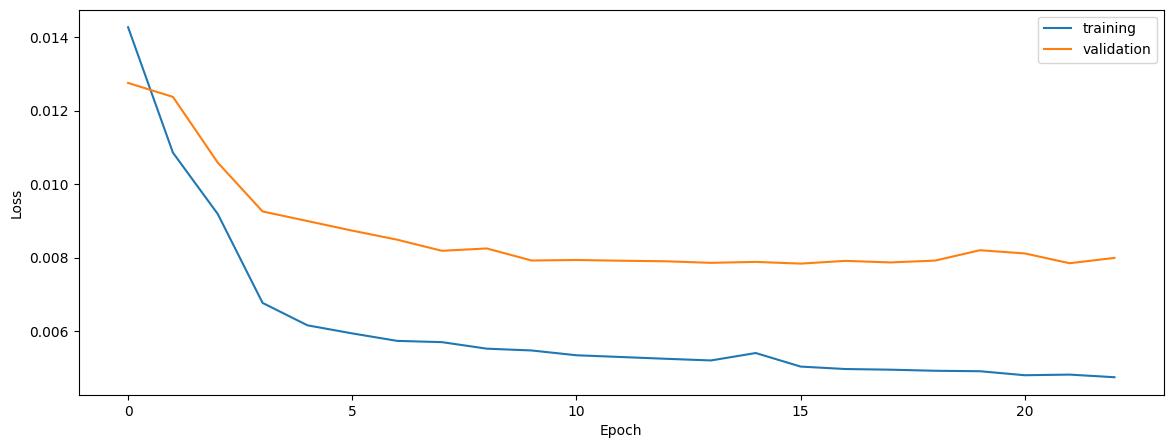

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7391046959254278
0.6234558172772626
0.6600767836951947


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7391046959254278
0.6234558172772626
0.6600767836951947


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.742614228758588
0.6447388859306558
0.6688514780145398


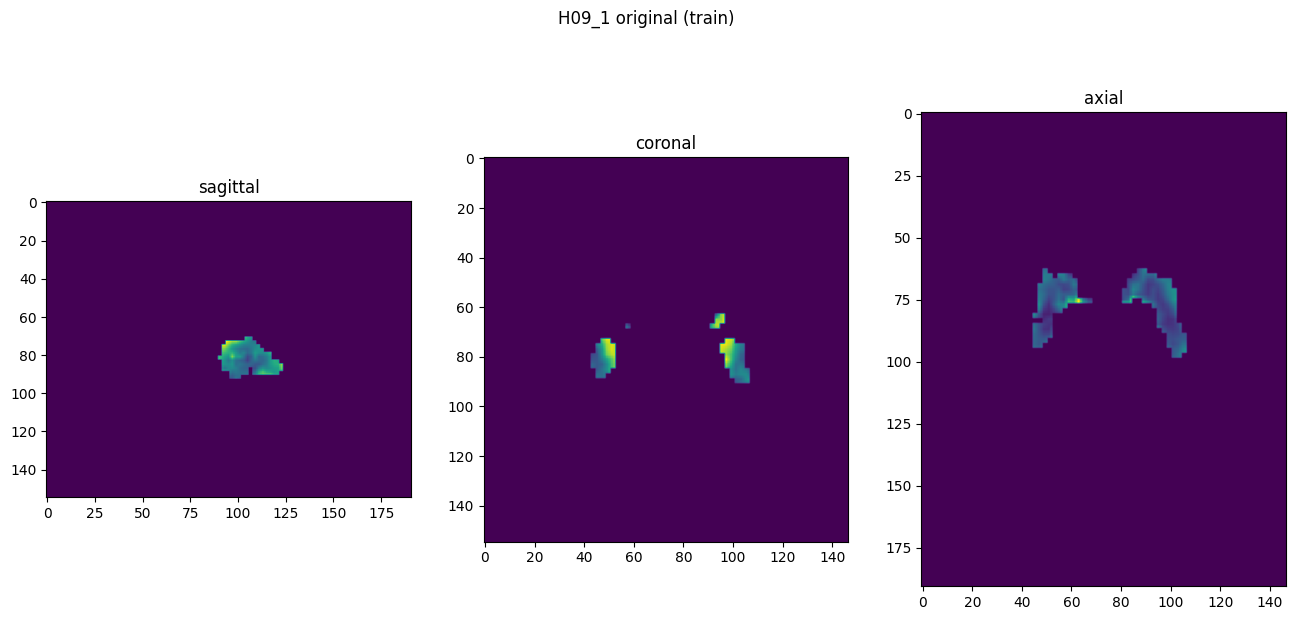

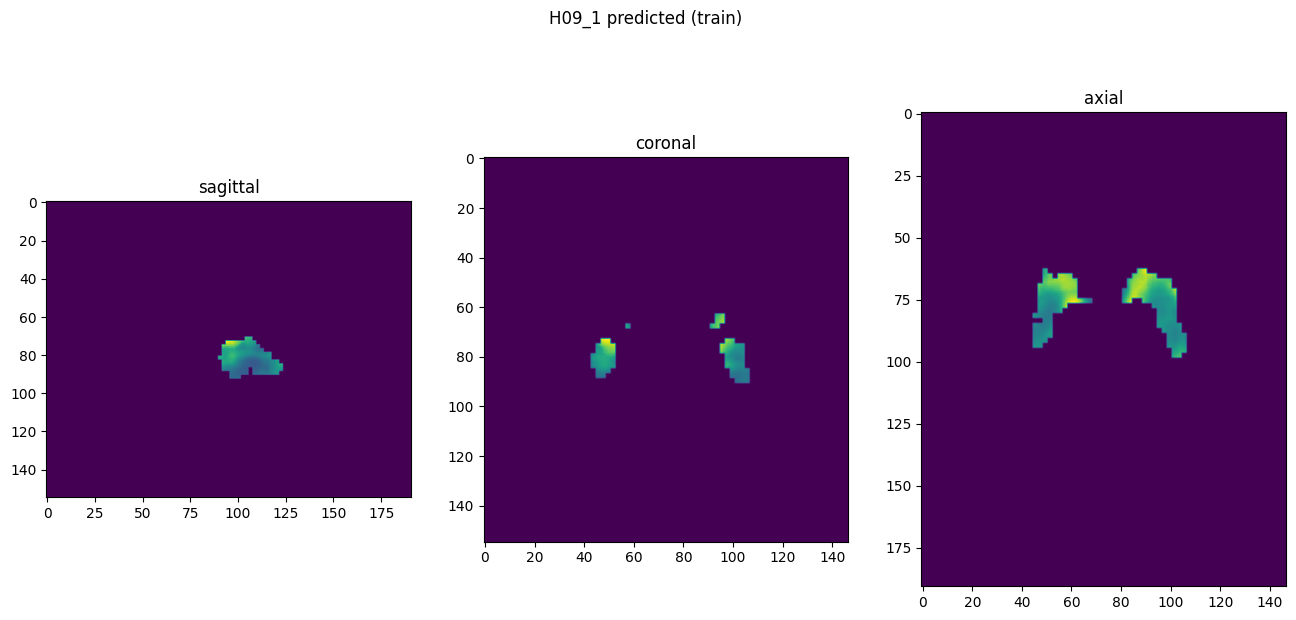

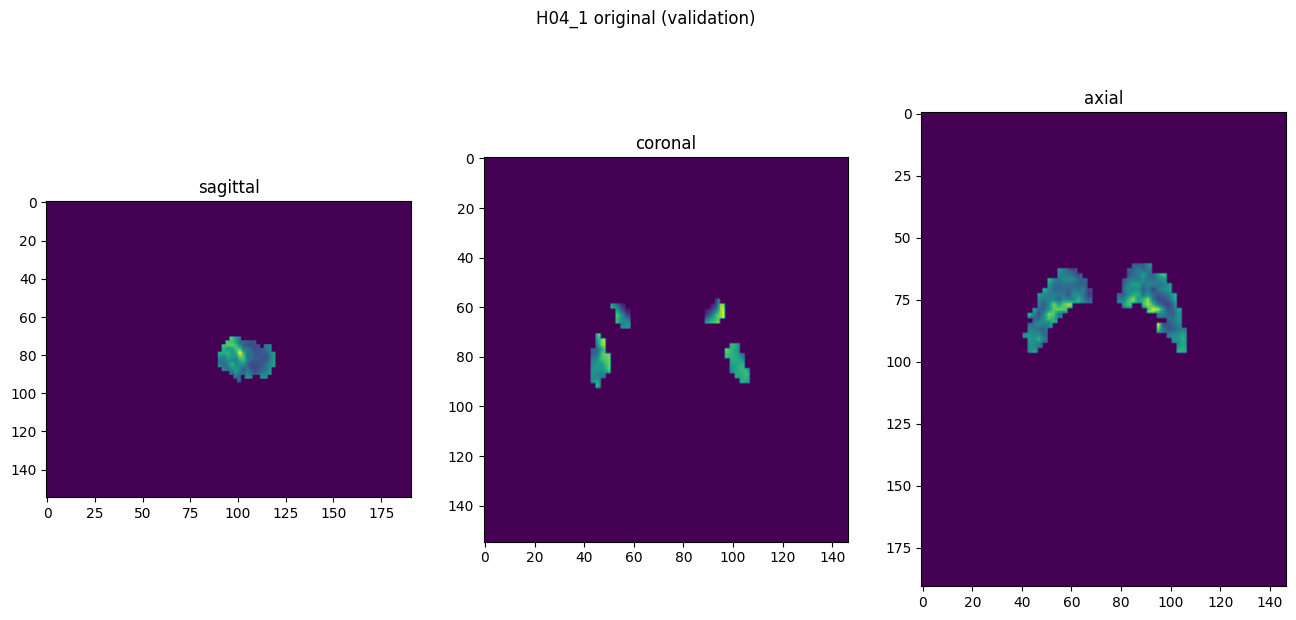

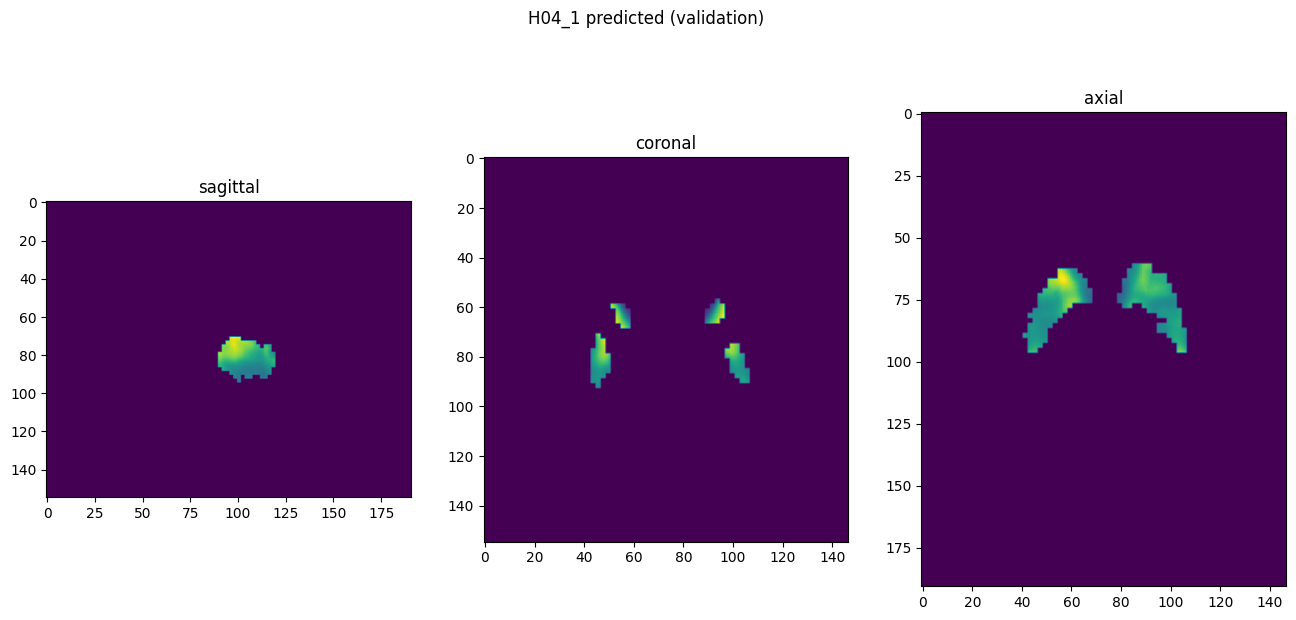

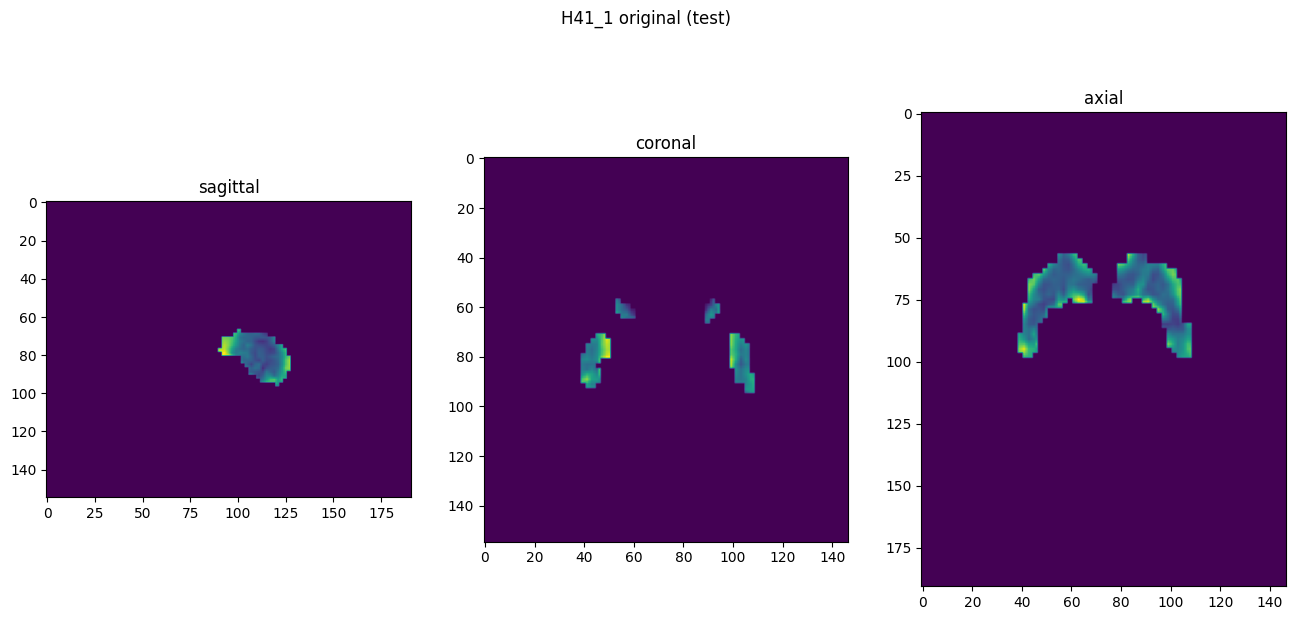

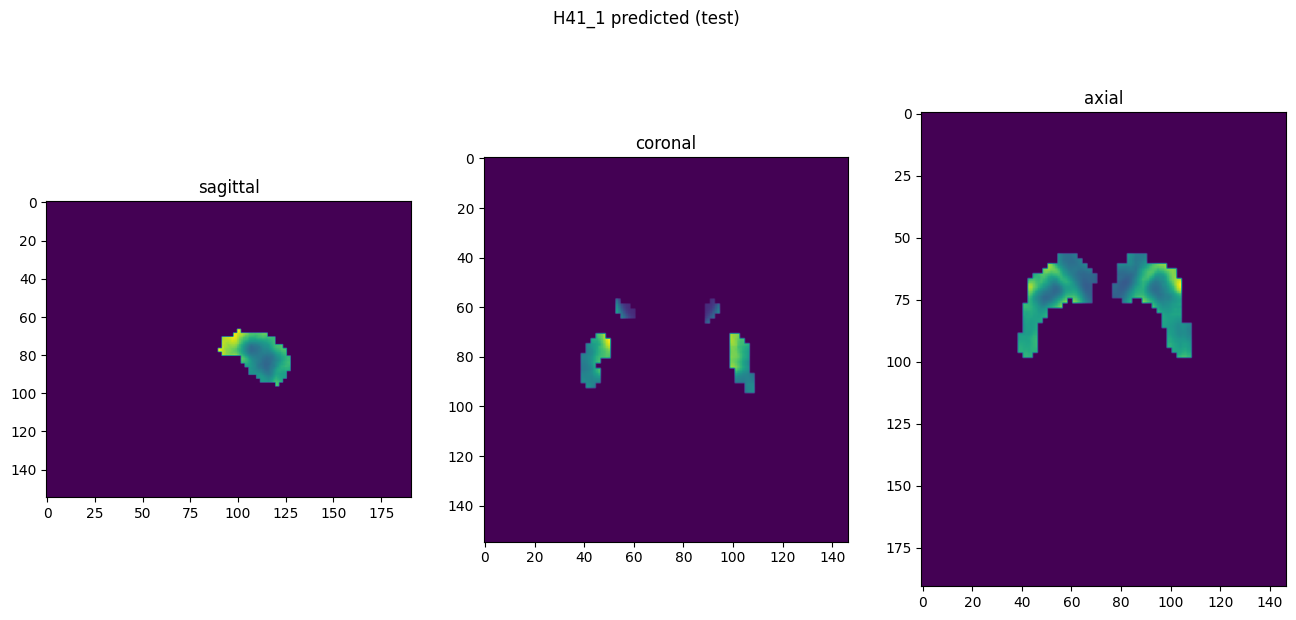

In [10]:
showResults(model, gen, threshold=None, background=False)